# M09-Desafío EPEC: Modelado y Optimización de Hábitos de Consumo de Energía Eléctrica 24

Práctico Nro 1

## 1.- Dominio del problema

Problema y contexto

La energía eléctrica es un servicio fundamental que permite el desarrollo de toda actividad humana. En general existen roles bien definidos en este mercado, hay generadores que están en condiciones de generar una cantidad de energía grande pero no ilimitada, hay transportistas que vinculan los generadores con los centros de consumo, y distruidores que reciben la energía y cuyo rol es lograr la capilaridad necesaria para vincular todos los usuarios a la red. El servicio de distribución es un monopolio natural prestado por distribuidoras que reciben un área de servicio exclusivo. Es función controlar las condiciones de calidad adecuadas a cada usuario y medir su consumo, esto es mantener la red balanceada y la potencia de cada eslabón dentro de los parámetros admisibles por los equipos (estaciones de transformación).

Siempre debe existir un equilibrio entre la energía eléctrica de generada y la consumida. Considerando el costo incremental y la dificultad que conlleva tener fuentes de generación flexibles, resulta interesante poder hacer una predicción lo más certera posible de las condiciones de demanda futura para poder pogramar el despacho de energía desde diferentes generadores.

La tarifa es la señal con la que cuenta el distribuidor para modelar la demanda. La tarifa puede variar por horario de consumo, pero también por tipo de consumir. La forma en que el usuario recibe esta "señal" es la factura, imagen que vemos aquí. 

Nuestro dataset contiene los datos esenciales agregados de todos los consumidores de un distribuidor determinado para el año 2023.


![alt text](https://ersep.cba.gov.ar/wp-content/uploads/2019/09/factura-Epec-frente-.jpg)

### Obejtivos Generales

Establecer un modelo de hábitos de consumo de la energía eléctrica en los tres tramos horarios establecidos por el mercado correlacionados por día hábil (weekday) o fin de semana (weekend), condiciones ambientales (temperatura y humedad) y por tipo tarifario.

Los tramos horarios son resto (5am a 6pm), pico, (6pm a 11pm) y valle (11pm a 5am).

Los hábitos de consumo estarán vinculados además a la demanda contratada con el fin de establecer el factor de uso de la misma.

El modelo establecido deberá tener la capacidad de constituir en un estimador válido de hábitos de consumo para suministros que no posean medidores inteligentes.

Con éste proyecto trataremos de responder algunas de las siguientes preguntas: 

Comportamiento de la demanda:
- Identificar la causa de los picos, valles y consumos medios.
- Identificar como afectan las variables exógenas (temperatura, humedad, lluvia, feriados, vacaciones, días laborales, datos socio económicos, subsidios, etc)
- Identificación de grupos tarifarios
- Predicción de la demanda energética
- Cuales subestaciones se encuentran sobredimensionadas.

## 2.- Carga de datos disponibles

Los datos fueron recibidos en un único archivo ''Clou_diario_diplo.rar''. Y se compone de diferentes datasets los cuales serán cargados en este notebook con las siguientes denominaciones:
* **consumos**: varios archivos con el registro mensual de los consumos y extensión ''*FINAL.csv''.
* **qgis**: ''QGIS_final.csv'' con los datos básicos del consumidor.
* **clima**: ''clima.txt'' un archivo con información de la condiciones del clima para diferentes estaciones metereológicas del país.
* **observatorio**: ''CORDOBA OBSERVATORIO.txt'' un archivo con información meterológica de diferentes variables para limitado a un área geográfica.

### 2.a. ETL

#### Carga de librerías necesarias para Extracción, Transformación y Carga.

In [866]:
import glob
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

#### Carga de datasets

##### Upload: Consumos mensuales de electricidad diario por device

In [867]:
# Son archivos mensuales CSV con ; como separador
archivos_cargados=[]

# Construcción del dataframe
consumos = pd.DataFrame()

# Carga de las lecturas mensuales de consumos
for each_file in glob.glob('*FINAL.csv'):
    archivos_cargados.append(each_file)
    datos_mes = pd.read_csv(each_file, sep=";", decimal=',')
    consumos = pd.concat([consumos, datos_mes])

*Rápida exploración de los datos*

In [868]:
consumos.shape

(1717933, 30)

In [869]:
consumos.head()

,DEVICE,TV,UPDATE_TV,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,VALUE10,VALUE11,VALUE12,VALUE13,VALUE14,VALUE15,VALUE16,VALUE17,VALUE18,VALUE19,VALUE20,VALUE21,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,RN
0,0,01/03/2023,01/03/2023,NaN,1923.249,1923.249,986.267,476.932,460.050,0.0,0.0,0.0,0.0,1436.120,813.981,282.264,339.875,0.0,0.0,0.0,0.0,0.976,2023-02-12 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,436592.0
1,0,02/03/2023,02/03/2023,NaN,1926.942,1926.942,988.037,477.729,461.176,0.0,0.0,0.0,0.0,1438.769,815.343,282.787,340.639,0.0,0.0,0.0,0.0,0.448,2023-03-01 05:45:00,NaN,NaN,NaN,NaN,NaN,NaN,157145.0
2,0,03/03/2023,03/03/2023,NaN,1931.674,1931.674,990.627,478.887,462.160,0.0,0.0,0.0,0.0,1442.144,817.263,283.486,341.395,0.0,0.0,0.0,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,336137.0
3,0,04/03/2023,04/03/2023,NaN,1935.935,1935.935,992.869,479.820,463.246,0.0,0.0,0.0,0.0,1444.999,818.838,284.039,342.122,0.0,0.0,0.0,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,411506.0
4,0,05/03/2023,05/03/2023,NaN,1939.996,1939.996,994.944,480.914,464.138,0.0,0.0,0.0,0.0,1448.147,820.682,284.596,342.869,0.0,0.0,0.0,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,369475.0


In [870]:
consumos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717933 entries, 0 to 141047
Data columns (total 30 columns):
 #   Column     Dtype  
---  ------     -----  
 0   DEVICE     int64  
 1   TV         object 
 2   UPDATE_TV  object 
 3   VALUE1     float64
 4   VALUE2     float64
 5   VALUE3     float64
 6   VALUE4     float64
 7   VALUE5     float64
 8   VALUE6     float64
 9   VALUE7     float64
 10  VALUE8     float64
 11  VALUE9     float64
 12  VALUE10    float64
 13  VALUE11    float64
 14  VALUE12    float64
 15  VALUE13    float64
 16  VALUE14    float64
 17  VALUE15    float64
 18  VALUE16    float64
 19  VALUE17    float64
 20  VALUE18    float64
 21  VALUE19    float64
 22  VALUE20    object 
 23  VALUE21    float64
 24  VALUE22    object 
 25  VALUE23    float64
 26  VALUE24    object 
 27  VALUE25    float64
 28  VALUE26    object 
 29  RN         float64
dtypes: float64(23), int64(1), object(6)
memory usage: 406.3+ MB


In [871]:
# Convert objects to datetime fields
consumos['TV'] = pd.to_datetime(consumos['TV'], format='%d/%m/%Y')
consumos['UPDATE_TV'] = pd.to_datetime(consumos['UPDATE_TV'], format='%d/%m/%Y')

In [872]:
# Get max and min date
min_date_consumption = consumos['TV'].min()
max_date_consumption = consumos['TV'].max()

# Calculate range days
range_days = (max_date_consumption - min_date_consumption).days

# Show range date
print(f'Rango de fechas: {min_date_consumption} al {max_date_consumption} ({range_days} días)')

Rango de fechas: 2023-01-01 00:00:00 al 2023-12-31 00:00:00 (364 días)


*💡 OBSERVACIONES*

- El datset contiene información sobre la medición diaria de energía por device para el año 2023 en la provincia de Córdoba.
- Contamos con más de 1.7M de entradas y 30 columnas.

*Atributos disponibles sobre la **medición**:*
```
 - DEVICE:       medidor con el que cuenta cada usuario para registrar el uso del servicio
 - TV:           fecha que corresponde al momento en que se realiza la medición
 - UPDATE_TV:    fecha que corresponde al momento en que se guarda el registro de la medición
 - Fecha_hora:   sin información
 ```

 *Atributos disponibles sobre la **energía**:*
```
 - VALUE1:       sin información
 - VALUE2:       Energia_Siempre_Positiva en Kwh: Energia_Directa (consumida) + Energia_Inversa (inyectada)
 - VALUE3:       Energía directa
 - VALUE4:       Energía directa resto
 - VALUE5:       Energía directa pico
 - VALUE6:       Energía directa valle
 - VALUE7:       Energía inversa
 - VALUE8:       Energía inversa resto
 - VALUE9:       Energía inversa pico
 - VALUE10:      Energía inversa valle
 - VALUE11:      sin información
 - VALUE12:      sin información
 - VALUE13:      sin información
 - VALUE14:      sin información
 - VALUE15:      sin información
 - VALUE16:      sin información
 - VALUE17:      sin información
 - VALUE18:      sin información
 - VALUE19:      Máxima demanda en Kw durante el día
 - VALUE20:      Fecha y hora
 - VALUE21:      sin información
 - VALUE22:      sin información
 - VALUE23:      sin información
 - VALUE24:      sin información
 - VALUE25:      sin información
 - VALUE26:      sin información
 - RN:           sin información
 ```

*💡 INFORMACIÓN ADCIONAL POR CONOCIMIENTO DE DOMINIO*

- La energía directa es el resultado de la suma de energía directa resto, pico y valle.
- La energía inversa es aquella que los usuarios generan y le aportan a la red.
- El *consumo* no está disponible como variable pero se calcula con el delta de la medición de la energía siempre positiva en dos tiempos distintos.
- Resto, pico y valle hacen referencia a la franja horaria, siendo las franjas de 05:00 a 18:00, de 18:00 a 23:00 y de 23:00 a 05:00 respectivamente.
- Las variables VALUE11, VALUE12, VALUE13, VALUE14 podrían estar relacionadas con la energía reactiva tomada de la red.
- Las variables VALUE15, VALUE16, VALUE17, VALUE18 podrían estar relacionadas con la energía reactiva inyectada a la red.
- Otra información contextual sobre cómo leer la factura: https://ersep.cba.gov.ar/energia-electrica/factura-epec/

Renomabrado de atributos de acuerdo a instrucciones del cliente:

In [873]:
# Rename columns based on given information 
consumos = consumos.rename(columns={
            'VALUE2': 'Energia_Siempre_Positiva', 'VALUE3': 'Energia_Directa', 'VALUE4': 'Energia_Directa_Resto',
            'VALUE5': 'Energia_Directa_Pico', 'VALUE6': 'Energia_Directa_Valle', 'VALUE7': 'Energia_Inversa', 
            'VALUE8': 'Energia_Inversa_Resto', 'VALUE9': 'Energia_Inversa_Pico', 
            'VALUE10': 'Energia_Inversa_Valle', 'VALUE19': 'Maxima_Demanda', 'VALUE20': 'Fecha_hora'})

##### Upload: QGIS (datos básicos del consumidor):

In [874]:
# Es un archivo CSV con ; como separador
qgis = pd.read_csv('QGIS_final.csv', sep=";", decimal=',')

*Exploración rápida del dataset*

In [875]:
# Take a look about the info
qgis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751 entries, 0 to 4750
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DEVICE                4751 non-null   int64  
 1   suministro            4751 non-null   object 
 2   cliente               4751 non-null   object 
 3   contrato              4751 non-null   int64  
 4   fecha_inicio          4751 non-null   object 
 5   sea                   4715 non-null   object 
 6   distribuidor          4751 non-null   object 
 7   subestacion           4744 non-null   float64
 8   zona                  4751 non-null   object 
 9   distrito              4751 non-null   int64  
 10  distrito_descripcion  4751 non-null   object 
 11  grupo_lectura         4750 non-null   object 
 12  ruta_lectura          4751 non-null   int64  
 13  orden_lectura         4751 non-null   int64  
 14  grupo_tarifario       4751 non-null   int64  
 15  codigo_tarifa        

In [876]:
qgis.shape

(4751, 17)

In [877]:
qgis.head()

,DEVICE,suministro,cliente,contrato,fecha_inicio,sea,distribuidor,subestacion,zona,distrito,distrito_descripcion,grupo_lectura,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa,tarifa
0,0,01_AA01,LZKVIR,3,2010-06-08Z,DBOSCO,13_ACHATEAU,5282.0,A,1,CORDOBA,1,1223,168,1,190,Residencial
1,1,01_AA02,EVLNRMZ,5,2014-05-06Z,DBOSCO,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,90,1,140,1.a/f RESIDENCIAL
2,2,01_AA03,RXXDNSQ,4,2023-10-25Z,DBOSCO,13_ACHATEAU,5076.0,A,1,CORDOBA,1,1223,414,1,140,1.a/f RESIDENCIAL
3,3,01_AA04,ZTHSMEW,2,2022-08-17Z,NaN,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,6,1,140,1.a/f RESIDENCIAL
4,4,01_AA05,IELVEK,1,1990-06-30Z,DFUNES,13_CARAFA,1685.0,A,1,CORDOBA,3,1261,37,1,140,1.a/f RESIDENCIAL


In [878]:
# Convert objects to datetime fields
qgis['fecha_inicio'] = pd.to_datetime(qgis['fecha_inicio'], format="%Y-%m-%dZ")

In [879]:
# Get max and min date
min_date_qgis = qgis['fecha_inicio'].min()
max_date_qgis = qgis['fecha_inicio'].max()

# Calculate range days
range_days_qgis = (max_date_qgis - min_date_qgis).days

# Show range date
print(f'Rango de fechas: {min_date_qgis} al {max_date_qgis} ({range_days_qgis} días)')

Rango de fechas: 1990-06-30 00:00:00 al 2024-06-04 00:00:00 (12393 días)


*💡 OBSERVACIONES*

- El datset contiene información sobre el consumidor y tipo de contrato así como también variables de entorno.
- Contamos con 4751 entradas y 17 columnas.
- El rango de `fecha_inicio` es amplio y podría indicar la fecha de inicio de contrato o instalación del medidor.

*Atributos disponibles:*
```
 - DEVICE:         medidor con el que cuenta cada usuario para registrar el uso del servicio
 - suministro:     número de medidor (innominado)
 - cliente:        nombre del cliente (innominado)
 - contrato:       veces que fue contratado el servicio por diferentes personas
 - distribuidor:   estación de media tensión que se utiliza para alimentar un grupo de subestaciones
 - subestacion:    subestación transformadora para llegar al consumidor con la tensión correcta
 ```

 *💡 INFORMACIÓN ADCIONAL POR CONOCIMIENTO DE DOMINIO*

- Las variables `DEVICE` y `suministro` identifican unívocamente al medidor.
- Las variables `distrito`, `distrito_descripcion`y `zona` hacen referencia a la geolocalización. Representan la misma información.
- La representación/granuralidad geográfica parece ser: `distrito/distrito_descripcion/zona -> sea -> distribuidor -> subestacion -> suministro/DEVICE`.
- La lectura del consumo se realiza agrupando usuarios en circuitos geográficamente próximos, con la siguiente lógica: `grupo_lectura > ruta_lectura > orden_lectura`.
- La variable `grupo_tarifario` agrupa las diferentes clases de tarifas.

##### Upload: Imformación climática (información de las condiciones del clima para diferentes estaciones metereológicas del país):

In [880]:
# Es un archivo de texto de ancho fijo
col_widths = [8, 6, 6, 40]

# Columnas disponibles
column_names = ['FECHA', 'TMAX', 'TMIN', 'NOMBRE']

# Nombre del archivo
file_path = 'clima.txt'

# Carga
clima = pd.read_fwf(file_path, widths=col_widths, skiprows=[2], header=0)


*Exploración rápida de los datos*

In [881]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43298 entries, 0 to 43297
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   43298 non-null  int64  
 1   TMAX    41138 non-null  float64
 2   TMIN    42243 non-null  float64
 3   NOMBRE  43298 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.3+ MB


In [882]:
clima.head()

,FECHA,TMAX,TMIN,NOMBRE
0,10062024,19.8,12.9,AEROPARQUE AERO
1,10062024,19.4,6.3,AZUL AERO
2,10062024,NaN,3.2,BAHIA BLANCA AERO
3,10062024,9.5,3.6,BARILOCHE AERO
4,10062024,-14.2,-21.1,BASE BELGRANO II


In [883]:
# Nos quedamos solo con mediciones de Córdoba (zona geográfica de nuestro distribuidor)
clima = clima.loc[clima['NOMBRE'].str.contains('CORDOBA')].reset_index(drop=True)

In [884]:
clima.shape

(730, 4)

In [885]:
# See all possible values and counts for specific column
clima.NOMBRE.value_counts(dropna=False)

NOMBRE
CORDOBA AERO            365
CORDOBA OBSERVATORIO    365
Name: count, dtype: int64

In [886]:
# Aux function to complete data values
def complete_with_left_zeros(value):
    if len(str(value)) < 8:
        return f'0{value}'
    else:
        return value

clima['FECHA'] = clima['FECHA'].apply(complete_with_left_zeros)

# Convert objects to datetime fields
clima['FECHA'] = pd.to_datetime(clima['FECHA'], format='%d%m%Y')

In [887]:
# Get max and min date
min_date_weather = clima['FECHA'].min()
max_date_weather = clima['FECHA'].max()

# Calculate range days
range_days_weather = (max_date_weather - min_date_weather).days

# Show range date
print(f'Rango de fechas: {min_date_weather} al {max_date_weather} ({range_days_weather} días)')

Rango de fechas: 2023-06-12 00:00:00 al 2024-06-10 00:00:00 (364 días)


*💡 OBSERVACIONES*

- El dataset contiene registros diarios de temperaturas máximas y mínimas para distintas regiones de Argentina a lo largo de 364 días pero no se corresponden estrictamente con el año 2023. 
- Como la base de consumo eléctrico es particularmente de la provincia Córdoba, sólo serán relevantes las mediciones climáticas para esta ubicación.
- Luego de filtrar, conservamos 730 registros para dos centros de medición: aeropuerto y observatorio.

##### Upload: Observatorio Córdoba (información meterológica de diferentes variables):

In [888]:
# Create a list with different information we have
meteorological_var = ['precipitaciones', 'temperatura_max', 'temperatura_min', 'temperatura_avg']
drop = [0, 3, 2, 2]

# Initial aux variables
df_list = []
skiprows = 5
aux = 0

for i, var in enumerate(meteorological_var):
    # Aux calculus
    skiprows = (31 * i) + (5 * (i+1)) + drop[i] + aux
    aux = aux + drop[i]
    
    # Create an empty DataFrame with dinamic name
    df = pd.DataFrame(columns=[var])
    
    # Read data
    df = pd.read_csv(
        'CORDOBA OBSERVATORIO.txt',
        sep=";", decimal=',',
        encoding ='latin1',
        skiprows=skiprows,
        nrows=31)
    
    # Delete last unnamed column
    last_column = df.columns[-1]
    df = df.drop(last_column, axis=1)
    
    # Add DF to our list
    df_list.append(df)

In [889]:
# Extract sparately each DF
precipitaciones = df_list[0]
temperatura_max = df_list[1]
temperatura_min = df_list[2]
temperatura_avg = df_list[3]

*Exploración rápida de los datos*

In [890]:
# Take a look about the info
precipitaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Día     31 non-null     int64 
 1   Ene     31 non-null     object
 2   Feb     28 non-null     object
 3   Mar     31 non-null     object
 4   Abr     30 non-null     object
 5   May     31 non-null     object
 6   Jun     30 non-null     object
 7   Jul     31 non-null     object
 8   Ago     31 non-null     object
 9   Sep     30 non-null     object
 10  Oct     31 non-null     object
 11  Nov     30 non-null     object
 12  Dic     31 non-null     object
dtypes: int64(1), object(12)
memory usage: 3.3+ KB


In [891]:
precipitaciones.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,"3,0","22,5",<0.1,<0.1,S/P,S/P,S/P,S/P,S/P,S/P,"10,0","0,6"
1,2,S/P,S/P,S/P,"2,0",<0.1,S/P,S/P,S/P,"3,0",S/P,S/P,"1,0"
2,3,"1,0",S/P,S/P,S/P,<0.1,<0.1,S/P,S/P,"0,2",S/P,S/P,"3,0"
3,4,S/P,S/P,S/P,<0.1,"9,0",<0.1,S/P,S/P,S/P,S/P,S/P,"4,0"
4,5,S/P,S/P,S/P,S/P,"9,0",S/P,S/P,S/P,S/P,S/P,S/P,"4,0"


*💡 OBSERVACIONES*

- El dataset contiene las precipitaciones diario en mm a lo largo de los meses (columnas) del año 2023 registradas por la estación metereológica de Córdoba (Observatorio).
- Las columnas son de tipo `object` y requerirán tratamiento posterior.

In [892]:
# Take a look about the info
temperatura_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Día     31 non-null     int64  
 1   Ene     31 non-null     float64
 2   Feb     31 non-null     object 
 3   Mar     31 non-null     float64
 4   Abr     31 non-null     object 
 5   May     31 non-null     float64
 6   Jun     31 non-null     object 
 7   Jul     31 non-null     float64
 8   Ago     31 non-null     float64
 9   Sep     31 non-null     object 
 10  Oct     31 non-null     float64
 11  Nov     31 non-null     object 
 12  Dic     31 non-null     float64
dtypes: float64(7), int64(1), object(5)
memory usage: 3.3+ KB


In [893]:
temperatura_max.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,30.1,"30,2",33.0,"24,7",20.0,"24,8",23.1,34.5,"28,6",29.0,"12,5",35.0
1,2,32.1,"28,2",37.8,"20,6",20.5,"27,4",27.6,30.0,"23,6",30.1,"14,4",33.0
2,3,31.5,"29,0",35.2,"26,6",19.2,"24,3",25.5,21.5,"13,6",24.4,"24,5",27.6
3,4,33.5,"29,0",37.5,"24,7",18.4,"19,2",30.1,23.3,"17,4",23.4,"27,5",18.3
4,5,35.5,"32,6",37.2,"25,4",16.5,"21,6",20.5,23.0,"17,4",27.7,"30,5",19.5


*💡 OBSERVACIONES*

- El dataset contiene las temperaturas máximas diarias en ºC a lo largo de los meses (columnas) del año 2023 registradas por la estación metereológica de Córdoba (Observatorio).
- Las columnas no tienen un tipo estándar, pudiendo encontrar `object` y `float64` que requerirán tratamiento posterior.

In [894]:
temperatura_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Día     31 non-null     int64  
 1   Ene     31 non-null     float64
 2   Feb     31 non-null     object 
 3   Mar     31 non-null     float64
 4   Abr     31 non-null     object 
 5   May     31 non-null     float64
 6   Jun     31 non-null     object 
 7   Jul     31 non-null     float64
 8   Ago     31 non-null     float64
 9   Sep     31 non-null     object 
 10  Oct     31 non-null     float64
 11  Nov     31 non-null     object 
 12  Dic     31 non-null     float64
dtypes: float64(7), int64(1), object(5)
memory usage: 3.3+ KB


In [895]:
temperatura_min.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,19.0,"20,9",23.0,"13,8",14.5,"8,5",5.5,15.2,"11,4",12.6,"9,2",23.8
1,2,15.0,"17,5",19.2,"18,0",12.5,"15,2",15.3,14.6,"8,5",15.2,"8,8",18.9
2,3,18.0,"19,0",20.6,"16,9",12.4,"14,6",13.1,14.2,"8,4",12.7,"4,8",10.8
3,4,17.5,"17,9",20.2,"18,2",11.8,"13,9",17.5,8.0,"9,5",7.0,"9,8",13.2
4,5,18.0,"17,8",21.9,"16,7",12.8,"12,7",14.9,12.9,"6,2",9.5,"14,0",12.7


*💡 OBSERVACIONES*

- El dataset contiene las temperaturas mínimas diarias en ºC a lo largo de los meses (columnas) del año 2023 registradas por la estación metereológica de Córdoba (Observatorio).
- Las columnas no tienen un tipo estándar, pudiendo encontrar `object` y `float64` que requerirán tratamiento posterior.

In [896]:
temperatura_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Día     31 non-null     int64  
 1   Ene     31 non-null     float64
 2   Feb     31 non-null     object 
 3   Mar     31 non-null     float64
 4   Abr     31 non-null     object 
 5   May     31 non-null     float64
 6   Jun     31 non-null     object 
 7   Jul     31 non-null     float64
 8   Ago     31 non-null     float64
 9   Sep     31 non-null     object 
 10  Oct     31 non-null     float64
 11  Nov     31 non-null     object 
 12  Dic     31 non-null     float64
dtypes: float64(7), int64(1), object(5)
memory usage: 3.3+ KB


In [897]:
temperatura_avg.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,22.6,"25,6",26.7,"18,9",16.6,"16,7",13.3,23.4,"19,5",20.6,"10,1",26.0
1,2,24.5,"22,2",27.9,"18,8",16.4,"20,5",20.8,20.5,"14,1",22.4,"11,3",26.4
2,3,24.5,"23,8",27.6,"20,8",15.4,"18,5",19.2,16.3,"10,5",17.5,"15,0",16.2
3,4,26.1,"23,5",28.2,"20,8",15.2,"15,7",22.1,14.6,"12,8",16.1,"20,0",15.8
4,5,27.5,"25,8",29.3,"20,8",14.7,"16,3",17.0,16.9,"12,0",19.0,"22,2",16.5


##### Upload: Datos de la actividad económica. 
Tomando el Estimador Mensual de Actividad Económica del portal de datos abiertos del Ministerio de Economía, Fuente: INDEC: https://www.economia.gob.ar/datos/

In [898]:
# Estimador Mensual de Actividad Económica. Fuente: https://www.economia.gob.ar/datos/
emae = pd.read_csv('actividad_ied.csv', sep=";", decimal='.', encoding ='latin1', skiprows=121, nrows=244)

In [899]:
emae = emae[['143.3_NO_PR_2004_A_13','143.3_NO_PR_2004_A_21']]

In [900]:
emae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   143.3_NO_PR_2004_A_13  244 non-null    object 
 1   143.3_NO_PR_2004_A_21  244 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [901]:
emae.head()

,143.3_NO_PR_2004_A_13,143.3_NO_PR_2004_A_21
0,01/04,92.6
1,02/04,90.2
2,03/04,101.9
3,04/04,102.6
4,05/04,109.9


In [902]:
emae = emae.rename(columns={'143.3_NO_PR_2004_A_13': 'Fecha', '143.3_NO_PR_2004_A_21': 'emae'})

In [903]:
emae = emae.replace('/','/01/20', regex=True)
emae['Fecha'] = pd.to_datetime(emae['Fecha'], format='%m/%d/%Y') 

In [904]:
emae = emae.loc[(emae['Fecha']>='2023-01-01') & (emae['Fecha']<='2023-12-31')].sort_values('Fecha')

In [905]:
# Get max and min date
min_date_emae = emae['Fecha'].min()
max_date_emae = emae['Fecha'].max()

# Calculate range days
range_days_emae = (max_date_emae - min_date_emae).days

# Show range date
print(f'Rango de fechas: {min_date_emae} al {max_date_emae} ({range_days_weather} días)')

Rango de fechas: 2023-01-01 00:00:00 al 2023-12-01 00:00:00 (364 días)


## Primeros hallazgos

In [906]:
# Show range date
print(f'Rango de fechas en consumos: {min_date_consumption} to {max_date_consumption} ({range_days} días)')
print(f'Rango de fechas en qgis: {min_date_qgis} al {max_date_qgis} ({range_days_qgis} días)')
print(f'Rango de fechas en clima: {min_date_weather} al {max_date_weather} ({range_days_weather} días)')
print(f'Rango de fechas en EMAE: {min_date_emae} al {max_date_emae} ({range_days_emae} días)')

Rango de fechas en consumos: 2023-01-01 00:00:00 to 2023-12-31 00:00:00 (364 días)
Rango de fechas en qgis: 1990-06-30 00:00:00 al 2024-06-04 00:00:00 (12393 días)
Rango de fechas en clima: 2023-06-12 00:00:00 al 2024-06-10 00:00:00 (364 días)
Rango de fechas en EMAE: 2023-01-01 00:00:00 al 2023-12-01 00:00:00 (334 días)


*💡 OBSERVACIONES*
- La información con el clima no se corresponde en forma completa con el año calendario 2023 como en consumos.
- La fecha en qgis no tiene relación con las mediciones diarias. Esto no representará un problema ya que se usará ese data set para obtener información del entorno.

### Variable Objetivo 
Evaluar si es posible llegar al objetivo planteado con los datos disponibles

*💡 OBSERVACIONES*
- El dataset principal tiene la indicación de la energía utilizada periódicamente, pero el consumo (target) es necesario calcularlo, no es una variable disponible.
- Contamos con información suficiente para hacer este cálculo: delta registrado para cada medidor de un día a otro.
- Tenemos información sobre las características de los consumidores. 
- Información sobre características de la tarifa pagada. 
- Indicaciones sobre rangos horarios de consumos. Información contextual sobre variables meteoreológicas.

### 2.d. Cantidad de observaciones y variables en el dataset.

In [907]:
print('Los datos disponibles de los dataset son:\n'
    '\nConsumos: ', consumos.shape,
    '\nQGIS:', qgis.shape,
    '\nClima:', clima.shape,
    '\nPrecipitaciones:', precipitaciones.shape,
    '\nTemperatura:',
    '\n  - Temperatura Mínima:',temperatura_min.shape,
    '\n  - Temperatura Máxima:', temperatura_max.shape,
    '\n  - Temperatura Promedio', temperatura_avg.shape,
    '\nEstimador Mensual de Actividad Económica:', emae.shape)

Los datos disponibles de los dataset son:

Consumos:  (1717933, 30) 
QGIS: (4751, 17) 
Clima: (730, 4) 
Precipitaciones: (31, 13) 
Temperatura: 
  - Temperatura Mínima: (31, 13) 
  - Temperatura Máxima: (31, 13) 
  - Temperatura Promedio (31, 13) 
Estimador Mensual de Actividad Económica: (12, 2)


*💡 OBSERVACIONES PARA ALCANZAR EL OBJETIVO*
- Contamos con información sobre las características de los consumidores.
- Contamos con información sobre las características de la tarifa pagada.
- Contamos con información sobre rangos horarios de consumos.
- Contamos con información contextual sobre variables meteoreológicas.
- Podemos asumir que es posible llegar al objetivo planteado.
- Desde el punto de vista histórico, tenemos información sobre un año de consumo.
- Sería deseable expandir el rango de los estudios a un período mayor. Mismo incorporar otras variables de tipo económicas dado que la variación de la actividad económica puede tener alta correlación con la energía necesaria para llevarla a cabo, variables de formas de energía alternatvias como combustibles, la tarifa efectivamente pagada por los usuarios.

## 3. Limpieza y revisión de Datos

### 3.a. Verificación inicial de datos faltantes y 3.b. Limpieza e imputación:

In [908]:
(round(consumos.isna().sum() * 100 / consumos.shape[0], 2)).astype(str) + "%"

DEVICE                        0.0%
TV                            0.0%
UPDATE_TV                     0.0%
VALUE1                      100.0%
Energia_Siempre_Positiva      0.0%
Energia_Directa               0.0%
Energia_Directa_Resto         0.0%
Energia_Directa_Pico          0.0%
Energia_Directa_Valle         0.0%
Energia_Inversa               0.0%
Energia_Inversa_Resto         0.0%
Energia_Inversa_Pico          0.0%
Energia_Inversa_Valle         0.0%
VALUE11                       0.0%
VALUE12                       0.0%
VALUE13                       0.0%
VALUE14                       0.0%
VALUE15                       0.0%
VALUE16                       0.0%
VALUE17                       0.0%
VALUE18                       0.0%
Maxima_Demanda                0.0%
Fecha_hora                    0.0%
VALUE21                     99.97%
VALUE22                     99.97%
VALUE23                     99.97%
VALUE24                     99.97%
VALUE25                     99.97%
VALUE26             

A partir de los porcentajes observados se decide la eliminación de una cantidad de atributos que no tienen una representación relevante de información en el dataset. Para lo cual definiremos un umbral a partir del cual dropeamos la columna.

In [909]:
# Umbral para eliminar columnas sin datos 
umbral = 90 # (90% en este caso)

for column in consumos.columns:
    # Calculando el porcentaje de valores no nulos en la columna
    porcentaje = consumos[column].count() / len(consumos) * 100
    
    # Si es menor al umbral
    if porcentaje < umbral:
        # eliminamos columna
        consumos.drop(column, axis=1, inplace=True)

In [910]:
(round(qgis.isna().sum() * 100 / qgis.shape[0], 2)).astype(str) + "%"

DEVICE                   0.0%
suministro               0.0%
cliente                  0.0%
contrato                 0.0%
fecha_inicio             0.0%
sea                     0.76%
distribuidor             0.0%
subestacion             0.15%
zona                     0.0%
distrito                 0.0%
distrito_descripcion     0.0%
grupo_lectura           0.02%
ruta_lectura             0.0%
orden_lectura            0.0%
grupo_tarifario          0.0%
codigo_tarifa            0.0%
tarifa                   0.0%
dtype: object

Para qgis consideramos suficiente mente completo los atributos. Realizaremos la imputación para aquellas variables que consideremos más relevantes

In [911]:
# TODO:
# Hacer una imputación con SimpleImputer usando la moda para cada tupla distribuidor y ruta_lectura
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1348) & (qgis['subestacion'].isna()), 'subestacion'] = 5209.0
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1287) & (qgis['subestacion'].isna()), 'subestacion'] = 3122.0
qgis.loc[(qgis['distribuidor']=='13_D2_SANLUIS') & (qgis['ruta_lectura']==1201) & (qgis['subestacion'].isna()), 'subestacion'] = 3193.0
qgis.loc[(qgis['distribuidor']=='13_OPERA') & (qgis['subestacion'].isna()), 'subestacion'] = 3982.0
qgis.loc[(qgis['distribuidor']=='13_D10_LIBERTAD') & (qgis['subestacion'].isna()), 'subestacion'] = 3638.0

#### Estandarización de datos. Se unificarán los formatos fecha para utilizar unas misma representación en todos los datasets

##### Consumos:

In [912]:
# Let's check fecha_hora variable
consumos.loc[consumos['Fecha_hora']=='FFFF-FF-FF  FF:FF:FF'][['DEVICE','TV','Fecha_hora']].head()

,DEVICE,TV,Fecha_hora
311,10,2023-03-02,FFFF-FF-FF FF:FF:FF
312,10,2023-03-03,FFFF-FF-FF FF:FF:FF
313,10,2023-03-04,FFFF-FF-FF FF:FF:FF
314,10,2023-03-05,FFFF-FF-FF FF:FF:FF
315,10,2023-03-06,FFFF-FF-FF FF:FF:FF


La corrección de valores erroneos será mediante la imputación con ffill

In [913]:
# Convert to datatime
# By using errors=coerce, we replace invalid values with NaT (Not a Time)
# By using ffill(), we fill in missing values (NaN) by copying the last non-missing value from the previous rows
consumos['Fecha_hora'] = pd.to_datetime(
    consumos['Fecha_hora'], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce').ffill()

*💡 OBSERVACIONES*

- Reemplazamos los valores inválidos de `Fecha_hora` con NaT y luego rellenamos con el valor de esa columna para la fila no nula previa.

##### Para precipitaciones:

Asignación de valores en las precipitaciones:

In [914]:
# S/P equivale a "no llovió", <0.1 equivale a 0.1
precipitaciones = precipitaciones.replace('S/P',0).replace('<0.1',0.1).replace(',','.', regex=True)

In [915]:
# conversión de string a numérico
precipitaciones = precipitaciones.apply(pd.to_numeric)

*💡 OBSERVACIONES*

- Ajustamos el tipo de dato en todo el DF, estandarizando la coma decimal y llevando a numérico los elementos de tipo object.

##### Para temperaturas:

In [916]:
# Let's see...
temperatura_min.sample(5)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
11,12,16.5,"26,9",26.5,"16,0",12.7,"0,4",7.1,7.5,"8,4",6.2,"16,4",22.0
8,9,23.0,"22,4",21.2,"19,0",10.5,"14,0",13.5,5.1,"7,0",15.9,"16,0",20.2
22,23,18.8,"15,7",19.0,"15,0",16.5,"6,2",9.2,7.8,"15,5",16.9,"18,5",20.4
25,26,20.5,"17,9",16.9,"11,4",17.2,"7,8",5.0,9.7,"12,5",14.0,"19,7",19.5
3,4,17.5,"17,9",20.2,"18,2",11.8,"13,9",17.5,8.0,"9,5",7.0,"9,8",13.2


In [917]:
# s/d equivale a "sin valor" o NaN, reemplazo de coma por punto.
temperatura_min = temperatura_min.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_avg = temperatura_avg.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_max = temperatura_max.replace('s/d',np.NaN).replace(',','.', regex=True)

In [918]:
# conversión de string a numérico
temperatura_min = temperatura_min.apply(pd.to_numeric, errors='coerce')
temperatura_avg = temperatura_avg.apply(pd.to_numeric, errors='coerce')
temperatura_max = temperatura_max.apply(pd.to_numeric, errors='coerce')

In [919]:
temperatura_avg.sample(5)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
13,14,25.8,27.3,23.2,14.8,19.6,7.6,7.5,18.2,17.6,19.3,21.1,25.6
4,5,27.5,25.8,29.3,20.8,14.7,16.3,17.0,16.9,12.0,19.0,22.2,16.5
29,30,26.7,NaN,20.2,19.6,13.5,13.4,16.9,21.1,17.4,18.2,22.5,23.2
2,3,24.5,23.8,27.6,20.8,15.4,18.5,19.2,16.3,10.5,17.5,15.0,16.2
3,4,26.1,23.5,28.2,20.8,15.2,15.7,22.1,14.6,12.8,16.1,20.0,15.8


In [920]:
temperatura_min.info() # -- Looks good
temperatura_max.info() # -- Looks good
temperatura_avg.info() # -- Looks good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Día     31 non-null     int64  
 1   Ene     31 non-null     float64
 2   Feb     28 non-null     float64
 3   Mar     31 non-null     float64
 4   Abr     30 non-null     float64
 5   May     31 non-null     float64
 6   Jun     30 non-null     float64
 7   Jul     31 non-null     float64
 8   Ago     31 non-null     float64
 9   Sep     30 non-null     float64
 10  Oct     31 non-null     float64
 11  Nov     30 non-null     float64
 12  Dic     31 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Día     31 non-null     int64  
 1   Ene     31 non-null     float64
 2   Feb     28 non-null     float64
 3 

*💡 OBSERVACIONES*

- Ajustamos el tipo de dato en todo el DF, estandarizando la coma decimal y llevando a numérico los elementos de tipo object.

### Revisión de duplicados

In [921]:
# See if there is any entire row duplicated
consumos.duplicated().sum()

0

In [922]:
# See if there is any entire row duplicated
qgis.duplicated().sum()

0

In [923]:
# See if there is any entire row duplicated
clima.duplicated().sum()

0

In [924]:
# Check for duplicate columns
column_match = consumos['Energia_Siempre_Positiva'].eq(consumos['Energia_Directa']).all()

# Check and print the result
if column_match:
    print("Los valores en las columnas son iguales.")
else:
    print("Los valores en las columnas no son iguales.")

Los valores en las columnas no son iguales.


### **Revisión de valores faltantes**

In [925]:
# Function to calculate percent of missing data
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()

    return percent_nan

In [926]:
# Calculate percent of missing data in consumption
percent_missing(consumos)

Series([], dtype: float64)

In [927]:
# Define thresold
threshold = 99

# Drop columns with more than our thresold of missing data
for column in consumos.columns:
    # Calculate percent of missing data
    percent = consumos[column].count() / len(consumos) * 100

    if percent < threshold:
        consumos.drop(column, axis=1, inplace=True)

*💡 OBSERVACIONES*

- Se deciden eliminar las columnas con más del 99% de datos faltantes.
- No quedan datos faltantes en consumption.

In [928]:
# Find percent of zero values on consumption
(consumos == 0).mean() * 100

DEVICE                       0.021246
TV                           0.000000
UPDATE_TV                    0.000000
Energia_Siempre_Positiva     0.134522
Energia_Directa              0.134522
Energia_Directa_Resto        0.161298
Energia_Directa_Pico         0.262001
Energia_Directa_Valle        0.461659
Energia_Inversa             93.523612
Energia_Inversa_Resto       94.702296
Energia_Inversa_Pico        97.507877
Energia_Inversa_Valle       97.598800
VALUE11                      0.294773
VALUE12                      0.382727
VALUE13                      0.662017
VALUE14                      1.461815
VALUE15                     94.714811
VALUE16                     95.832142
VALUE17                     98.046373
VALUE18                     98.098471
Maxima_Demanda               1.239455
Fecha_hora                   0.000000
RN                           0.000000
dtype: float64

In [929]:
# Define thresold
threshold = 90

# Drop columns with more than our thresold of zero values
for column in consumos.columns:
    # Calculate percent of zero values
    percent = consumos[column][consumos[column] == 0].count() / len(consumos) * 100

    if percent > threshold:
        consumos.drop(column, axis=1, inplace=True)

*💡 OBSERVACIONES*

- Se deciden eliminar las columnas con más del 90% de valores cero por no aportar información: los valores de inyección de energía a la red son mínimos y para el resto de columnas no tenemos información de dominio. 

In [930]:
# Calculate percent of missing data in qgis
percent_nan_qgis =  percent_missing(qgis)
percent_nan_qgis

subestacion      0.021048
grupo_lectura    0.021048
sea              0.757735
dtype: float64

*💡 OBSERVACIONES*

- El porcentaje de valores faltantes en qgis es mínimo, se decide dar tratamiento a estos casos.

In [931]:
# Let's check missing rows in grupo_lectura column 
qgis[qgis['grupo_lectura'].isnull()].shape

(1, 17)

In [932]:
# Find the index of the first row with NaN in 'grupo_lectura'
index_row_nan = qgis[qgis['grupo_lectura'].isnull()].index
index_row_nan

Index([3715], dtype='int64')

In [933]:
qgis['subestacion'][3715]

2812.0

In [934]:
# Filter rows where 'subestacion' is equal to 2812
qgis_filtrado = qgis[qgis['subestacion'] == 2812]
qgis_filtrado.sample(10)

,DEVICE,suministro,cliente,contrato,fecha_inicio,sea,distribuidor,subestacion,zona,distrito,distrito_descripcion,grupo_lectura,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa,tarifa
669,669,01_CO10,VOADMCV,1,2016-09-06,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1253,129,1,140,1.a/f RESIDENCIAL
130,130,01_AN01,BORYWO,1,2006-12-28,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,7,1,140,1.a/f RESIDENCIAL
3715,3715,01_OH06,EBWPSC,1,2005-02-24,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,NaN,29150,953,1,140,1.a/f RESIDENCIAL
132,132,01_AN03,ZYIIGB,2,1996-12-30,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,137,1,140,1.a/f RESIDENCIAL
139,139,01_AN10,ERBSWM,1,1990-06-30,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,158,1,140,1.a/f RESIDENCIAL
4287,4287,01_QM08,FHKTLBM,2,2006-12-15,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,8,1,140,1.a/f RESIDENCIAL
131,131,01_AN02,YUSYZQO,1,2021-07-30,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,1,1,140,1.a/f RESIDENCIAL
4284,4284,01_QM05,LKDEIA,1,1998-10-14,CERRO,13_OPERA,2812.0,A,1,CORDOBA,1,1091,117,5,545,5.2.b USUAR. ESPECIALES
255,255,01_AZ06,YBIIQC,1,1990-06-30,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1091,162,1,140,1.a/f RESIDENCIAL
253,253,01_AZ04,ZWQGBP,3,2008-01-16,DFUNES,13_OPERA,2812.0,A,1,CORDOBA,1,1253,496,1,140,1.a/f RESIDENCIAL


In [935]:
# Assign the value to the specified position
qgis.at[3715, 'grupo_lectura'] = '1'

*💡 OBSERVACIONES*

- Inputamos de manera manual el único dato faltante para `grupo_lectura` habiendo comparado la columna `subestacion` y encontrando un posible patrón válido.

In [936]:
# Let's check missing data in subestacion column
qgis[qgis['subestacion'].isnull()]

,DEVICE,suministro,cliente,contrato,fecha_inicio,sea,distribuidor,subestacion,zona,distrito,distrito_descripcion,grupo_lectura,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa,tarifa
3578,3578,01_NT09,YMQACPV,1,2022-01-20,VALLEN,13_D4_SALDAN,NaN,A,1,CORDOBA,3,1202,1,1,184,Resid TSP Indig Dto. 43/19


In [937]:
# Define a function to fill NaN values with mode if at least one non-null value exists
def fillna_mode(x):
    if x.notna().any():
        return x.fillna(x.mode().iloc[0])
    else:
        return x

In [938]:
# Group by 'ruta_lectura' and fill NaN values in 'subestacion' column
qgis['subestacion'] = qgis.groupby('ruta_lectura')['subestacion'].transform(fillna_mode)

In [939]:
# Let's see an example of value added by imputation
qgis['subestacion'][3726]

3193.0

*💡 OBSERVACIONES*

- La columna `subestacion`es imputada usando `ruta_lectura` como proxy y la `moda` como estrategia de imputación. 

In [940]:
# Calculate percent of missing data in qgis
percent_nan_qgis =  percent_missing(qgis)
percent_nan_qgis

sea    0.757735
dtype: float64

In [941]:
# Let's check missing data in sea column
qgis[qgis['sea'].isnull()].shape

(36, 17)

In [942]:
# Group by 'distribuidor' and fill NaN values in 'sea' column
qgis['sea'] = qgis.groupby('distribuidor')['sea'].transform(fillna_mode)

*💡 OBSERVACIONES*

- La columna `sea`es imputada usando `distribuidor` como proxy y la `moda` como estrategia de imputación. 

In [943]:
# Calculate percent of missing data in qgis
percent_nan_qgis =  percent_missing(qgis)
percent_nan_qgis

Series([], dtype: float64)

*💡 OBSERVACIONES*

- No quedan datos faltantes en qgis.

In [944]:
# Find percent of zero values on qgis
(qgis == 0).mean() * 100

DEVICE                  0.021048
suministro              0.000000
cliente                 0.000000
contrato                0.000000
fecha_inicio            0.000000
sea                     0.000000
distribuidor            0.000000
subestacion             0.000000
zona                    0.000000
distrito                0.000000
distrito_descripcion    0.000000
grupo_lectura           0.000000
ruta_lectura            0.000000
orden_lectura           0.000000
grupo_tarifario         0.000000
codigo_tarifa           0.000000
tarifa                  0.000000
dtype: float64

*💡 OBSERVACIONES*

- No hay valores cero en qgis.

In [945]:
# Calculate percent of missing data in weather
percent_missing(clima)

Series([], dtype: float64)

*💡 OBSERVACIONES*

- No hay datos faltantes en clima.

In [946]:
# Calculate percent of missing data in precipitations
percent_missing(precipitaciones)

Abr    3.225806
Jun    3.225806
Sep    3.225806
Nov    3.225806
Feb    9.677419
dtype: float64

In [947]:
# Let's check missing data in Jun column
precipitaciones[precipitaciones['Jun'].isnull()]

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
30,31,0.0,NaN,0.8,NaN,0.0,NaN,0.0,0,NaN,0.1,NaN,73.0


*💡 OBSERVACIONES*

- Los datos faltantes corresponden a días que no existen para los meses dados: Abr, Jun, Sep y Nov tienen 30 días y Feb 28.
- Lo mismo ocurre en temperatura_min, temperature_max y temperature_avg.

### Dominio de Conocimiento

In [948]:
# Drop multiple columns
consumos = consumos.drop(columns=['VALUE11', 'VALUE12', 'VALUE13', 'VALUE14', 'RN', 'Fecha_hora', 'UPDATE_TV'])

*💡 OBSERVACIONES*

- Se deciden eliminar columnas para las cuales no se dispone de información respecto de su naturaleza.
- Se deciden eliminar columnas que por conocimiento de dominio no aportan valor al problema.

### Existencia de outliers

In [949]:
consumos.describe()

,DEVICE,TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Maxima_Demanda
count,1.717933e+06,1717933,1.717933e+06,1.717933e+06,1.717933e+06,1.717933e+06,1.717933e+06,1.717933e+06
mean,2.372899e+03,2023-07-01 21:50:32.548301056,5.384631e+03,5.372555e+03,2.870959e+03,1.328645e+03,1.172950e+03,2.052545e+00
min,0.000000e+00,2023-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.189000e+03,2023-04-02 00:00:00,2.300747e+03,2.292344e+03,1.157490e+03,5.779250e+02,4.907700e+02,9.880000e-01
50%,2.374000e+03,2023-07-02 00:00:00,3.691378e+03,3.682651e+03,1.869123e+03,9.377730e+02,8.158450e+02,1.700000e+00
75%,3.559000e+03,2023-10-01 00:00:00,5.820054e+03,5.809131e+03,3.019136e+03,1.473331e+03,1.303289e+03,2.520000e+00
max,4.750000e+03,2023-12-31 00:00:00,2.864273e+05,2.864239e+05,1.519924e+05,6.501157e+04,8.058427e+04,4.956400e+01
std,1.370536e+03,NaN,8.894518e+03,8.876607e+03,5.059177e+03,2.155773e+03,2.086770e+03,2.096081e+00


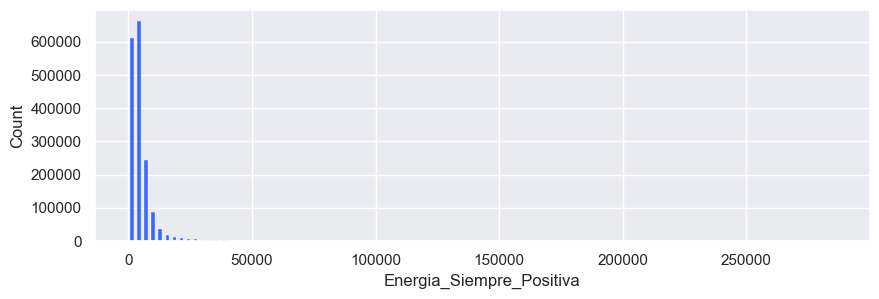

In [950]:
# Plot Energia_Siempre_Positiva distribution
fig = plt.figure(figsize=(10, 3))
sns.histplot(consumos['Energia_Siempre_Positiva'],bins = 100,shrink = 0.5,stat = 'count')

# Avoid scientific notation on labels
plt.ticklabel_format(style='plain', axis='x')

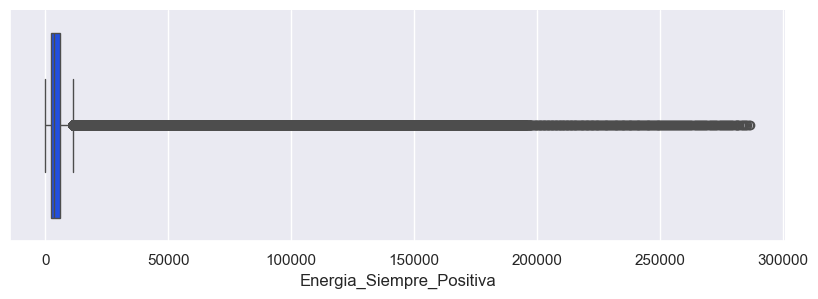

In [951]:
# Take a look at the box plot for outliers
plt.figure(figsize=(10, 3))
sns.boxplot(x=consumos['Energia_Siempre_Positiva'])
sns.despine()

In [952]:
# Let's check for outliers in qgis
qgis.describe()

,DEVICE,contrato,fecha_inicio,subestacion,distrito,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa
count,4751.000000,4751.000000,4751,4751.000000,4751.000000,4751.000000,4751.000000,4751.000000,4751.000000
mean,2375.000000,2.611871,2009-03-05 16:14:26.849084416,2993.556725,1.018522,1371.888024,163.217638,1.141444,162.072195
min,0.000000,1.000000,1990-06-30 00:00:00,58.000000,1.000000,52.000000,1.000000,1.000000,10.000000
25%,1187.500000,1.000000,2000-12-19 12:00:00,2296.000000,1.000000,1224.000000,58.500000,1.000000,140.000000
50%,2375.000000,2.000000,2011-03-03 00:00:00,3121.000000,1.000000,1282.000000,132.000000,1.000000,140.000000
75%,3562.500000,3.000000,2019-01-23 00:00:00,3632.000000,1.000000,1470.000000,224.000000,1.000000,180.000000
max,4750.000000,20.000000,2024-06-04 00:00:00,5883.000000,23.000000,29150.000000,1274.000000,6.000000,1800.000000
std,1371.639894,2.120789,NaN,1302.534720,0.638150,1056.028580,145.503604,0.503660,68.899179


In [953]:
# Let's check for outliers in weather
clima.describe()

,FECHA,TMAX,TMIN
count,730,730.000000,730.000000
mean,2023-12-11 00:00:00,25.405068,12.342877
min,2023-06-12 00:00:00,7.500000,-6.700000
25%,2023-09-11 00:00:00,20.500000,7.500000
50%,2023-12-11 00:00:00,26.300000,12.750000
75%,2024-03-11 00:00:00,30.800000,17.600000
max,2024-06-10 00:00:00,43.700000,27.100000
std,NaN,6.856774,6.552272


In [954]:
# Let's check for outliers in precipitations
precipitaciones.describe()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
count,31.000000,31.000000,28.000000,31.00000,30.000000,31.000000,30.000000,31.000000,31.0,30.000000,31.000000,30.000000,31.000000
mean,16.000000,4.316129,1.417857,4.90000,0.983333,0.890323,0.010000,0.545161,0.0,0.240000,0.441935,2.776667,4.516129
std,9.092121,9.651083,4.710119,12.86253,3.523623,2.698685,0.030513,1.880574,0.0,0.726636,1.332110,7.308318,13.345613
min,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,8.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.100000
75%,23.500000,2.500000,0.000000,1.90000,0.100000,0.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.500000
max,31.000000,45.000000,22.500000,67.00000,19.000000,9.000000,0.100000,9.500000,0.0,3.000000,4.700000,26.500000,73.000000


In [955]:
# Let's check for outliers in temperature
temperatura_avg.describe()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
count,31.000000,31.000000,28.000000,31.000000,30.000000,31.000000,30.000000,31.000000,31.000000,30.000000,31.000000,30.000000,31.000000
mean,16.000000,26.587097,24.792857,25.574194,19.543333,16.945161,13.053333,13.167742,15.816129,17.063333,20.722581,22.976667,24.141935
std,9.092121,2.849414,4.140579,3.534682,2.814456,2.804026,4.007212,4.123864,3.408039,3.433756,3.653556,4.692083,4.176743
min,1.000000,19.400000,13.700000,19.200000,14.400000,11.200000,6.100000,6.100000,11.400000,10.500000,13.600000,10.100000,15.600000
25%,8.500000,24.500000,23.050000,22.700000,17.400000,15.200000,10.450000,9.750000,13.250000,14.700000,17.900000,21.350000,22.550000
50%,16.000000,26.200000,25.550000,26.700000,19.150000,16.600000,12.600000,13.000000,15.100000,17.300000,20.400000,23.200000,25.300000
75%,23.500000,28.800000,27.600000,28.100000,21.475000,18.650000,16.150000,16.600000,17.150000,19.500000,22.800000,25.525000,26.400000
max,31.000000,31.600000,32.400000,31.400000,24.100000,22.700000,21.500000,22.100000,23.400000,22.900000,29.300000,30.500000,29.800000


*💡 OBSERVACIONES*

- En consumos se observan algunos valores que podrían ser anormales pero dado que la energía es incremental con el tiempo, se deja para más adelante la revisión de outliers (luego del cálculo del consumo)
- Por conocimiento de dominio entendemos que las variables en qgis son de tipo categóricas y no aplica la revisión de outliers.
- No se observan anomalías en los datasets de condiciones climáticas.

## 4. Ingeniería de Atributos 

In [956]:
# Aux function to transform calendar-formatted DF
def transform_df(df, feature_name):
    # Melt data to transform months into rows
    df_melted = pd.melt(df, id_vars=['Día'], var_name='Mes', value_name=feature_name)
    
    # Map month names into numbers
    meses = {'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6, 
             'Jul': 7, 'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12}
    
    df_melted['Mes'] = df_melted['Mes'].map(meses)
    
    # Filter NaN values
    df_melted = df_melted.dropna(subset=[feature_name])
    
    # Create year column
    df_melted['Año'] = 2023
    
    # Create date column
    df_melted['Fecha'] = pd.to_datetime(df_melted[['Año', 'Mes', 'Día']].rename(columns={'Año': 'year', 'Mes': 'month', 'Día': 'day'}))
    
    # Delete aux columns
    df_final = df_melted.drop(columns=['Día', 'Mes', 'Año'])
    
    # Sort columns
    df_final = df_final[['Fecha', feature_name]]
    
    return df_final.reset_index(drop=True)

In [957]:
# Apply transformations to our datasets
df_precipitaciones = transform_df(precipitaciones, 'precipitaciones')
df_temperatura_min = transform_df(temperatura_min, 'temperatura_min')
df_temperatura_max = transform_df(temperatura_max, 'temperatura_max')
df_temperatura_avg = transform_df(temperatura_avg, 'temperatura_avg')

In [958]:
# Combine all datasets into one
clima_df = pd.merge(df_precipitaciones, df_temperatura_min, on='Fecha')
clima_df = pd.merge(clima_df, df_temperatura_max , on='Fecha')
clima_df = pd.merge(clima_df, df_temperatura_avg, on='Fecha')

In [959]:
clima_df = clima_df.merge(emae, how='left', on='Fecha')

# Datos del Estimador Mensual de Actividad Económica son mensuales. Repetimos el dato para cada día del mes
clima_df.ffill(inplace=True)

In [960]:
# Seea a sample of created weather_df
clima_df.sample(10)

,Fecha,precipitaciones,temperatura_min,temperatura_max,temperatura_avg,emae
141,2023-05-22,0.0,12.0,23.5,17.6,152.7
274,2023-10-02,0.0,15.2,30.1,22.4,146.7
284,2023-10-12,0.0,6.2,21.0,13.6,146.7
13,2023-01-14,0.0,15.8,34.5,25.8,143.0
121,2023-05-02,0.1,12.5,20.5,16.4,152.7
320,2023-11-17,0.0,18.3,35.5,25.2,145.5
133,2023-05-14,0.0,11.6,30.0,19.6,152.7
327,2023-11-24,0.1,19.2,29.7,25.0,145.5
323,2023-11-20,0.0,20.8,38.4,29.2,145.5
45,2023-02-15,10.0,21.5,36.0,27.9,137.6


In [961]:
# Add weather information to our consumption dataset
consumos_df = consumos.merge(clima_df, how='left', left_on='TV', right_on='Fecha')

# Delete 'Fecha' column (duplicated)
consumos_df.drop(columns=['Fecha'], inplace=True)

# See result
consumos_df.head()

,DEVICE,TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Maxima_Demanda,precipitaciones,temperatura_min,temperatura_max,temperatura_avg,emae
0,0,2023-03-01,1923.249,1923.249,986.267,476.932,460.050,0.976,0.1,23.0,33.0,26.7,155.4
1,0,2023-03-02,1926.942,1926.942,988.037,477.729,461.176,0.448,0.0,19.2,37.8,27.9,155.4
2,0,2023-03-03,1931.674,1931.674,990.627,478.887,462.160,0.732,0.0,20.6,35.2,27.6,155.4
3,0,2023-03-04,1935.935,1935.935,992.869,479.820,463.246,0.732,0.0,20.2,37.5,28.2,155.4
4,0,2023-03-05,1939.996,1939.996,994.944,480.914,464.138,0.732,0.0,21.9,37.2,29.3,155.4


*💡 OBSERVACIONES*

- Transformamos y combinamos los datos del observatorio de Córdoba para las precipitaciones y temperaturas en un único dataset.
- Se decide descartar el dataset weather (clima.txt) por no contener información suficiente (los rangos de fecha calculados indican que sólo disponemos de información para la segunda mitad del año 2023)
- Se crea consumption_df con la información agregada del clima.

In [962]:
# Find the intersection between two columns
intersection = set(consumos_df['DEVICE']).intersection(qgis['DEVICE'])
print('consumos_df unique DEVICE', len(consumos_df.DEVICE.unique()))
print('QGIS unique DEVICE', len(qgis.DEVICE.unique()))

print('Intersección de las columnas:')
print(len(intersection))

consumos_df unique DEVICE 4751
QGIS unique DEVICE 4751
Intersección de las columnas:
4751


In [963]:
# Define relevant columns in qgis
relevant_col_qgis = ['DEVICE', 'distribuidor','subestacion', 'distrito', 'grupo_tarifario', 'tarifa']

qgis_df = qgis[relevant_col_qgis]
qgis_df.head()

,DEVICE,distribuidor,subestacion,distrito,grupo_tarifario,tarifa
0,0,13_ACHATEAU,5282.0,1,1,Residencial
1,1,13_ACHATEAU,5311.0,1,1,1.a/f RESIDENCIAL
2,2,13_ACHATEAU,5076.0,1,1,1.a/f RESIDENCIAL
3,3,13_ACHATEAU,5311.0,1,1,1.a/f RESIDENCIAL
4,4,13_CARAFA,1685.0,1,1,1.a/f RESIDENCIAL


In [964]:
# Add customer information to our consumption dataset
consumos_df = consumos_df.merge(qgis_df, how='left', on='DEVICE')

*💡 OBSERVACIONES*

- Agregamos información del cliente y entorno provenientes del dataset qgis a nuestro consumption_df

### Nuevas Variables

In [965]:
consumos_df.head()

,DEVICE,TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Maxima_Demanda,precipitaciones,temperatura_min,temperatura_max,temperatura_avg,emae,distribuidor,subestacion,distrito,grupo_tarifario,tarifa
0,0,2023-03-01,1923.249,1923.249,986.267,476.932,460.050,0.976,0.1,23.0,33.0,26.7,155.4,13_ACHATEAU,5282.0,1,1,Residencial
1,0,2023-03-02,1926.942,1926.942,988.037,477.729,461.176,0.448,0.0,19.2,37.8,27.9,155.4,13_ACHATEAU,5282.0,1,1,Residencial
2,0,2023-03-03,1931.674,1931.674,990.627,478.887,462.160,0.732,0.0,20.6,35.2,27.6,155.4,13_ACHATEAU,5282.0,1,1,Residencial
3,0,2023-03-04,1935.935,1935.935,992.869,479.820,463.246,0.732,0.0,20.2,37.5,28.2,155.4,13_ACHATEAU,5282.0,1,1,Residencial
4,0,2023-03-05,1939.996,1939.996,994.944,480.914,464.138,0.732,0.0,21.9,37.2,29.3,155.4,13_ACHATEAU,5282.0,1,1,Residencial


In [966]:
# Create new column with week day name
# 0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'
consumos_df['Dia_Consumo'] = consumos_df['TV'].dt.dayofweek # Categorizada

# Create new column Mes del año en el cual se realiza la medición.
consumos_df['Mes_Consumo'] = pd.DatetimeIndex(consumos['TV']).month

In [967]:
# Define holidays in Argentina 2023
holidays_2023 = [
    '2023-01-01',  # Año Nuevo
    '2023-02-20',  # Carnaval
    '2023-02-21',  # Carnaval
    '2023-03-24',  # Día de la Memoria
    '2023-04-07',  # Viernes Santo
    '2023-05-01',  # Día del Trabajador
    '2023-05-25',  # Día de la Revolución de Mayo
    '2023-06-17',  # Paso a la Inmortalidad del General Don Martín Miguel de Güemes
    '2023-06-20',  # Paso a la Inmortalidad del General Manuel Belgrano
    '2023-07-09',  # Día de la Independencia
    '2023-08-21',  # Paso a la Inmortalidad del General José de San Martín (Feriado trasladable)
    '2023-10-16',  # Día del Respeto a la Diversidad Cultural (Feriado trasladable)
    '2023-11-20',  # Día de la Soberanía Nacional
    '2023-12-08',  # Inmaculada Concepción de María
    '2023-12-25'   # Navidad
    ]

non_business_days_2023 = [
    '2023-04-06',  # Jueves Santo
    '2023-04-24',  # Día de acción por la tolerancia y el respeto entre los pueblos
    '2023-05-26',  # Feriado con fines turísticos
    '2023-06-19',  # Feriado con fines turísticos
    '2023-10-13',  # Feriado con fines turísticos
    ]

# Is business_day function
def is_business_day(date):
    is_weekend = bool(date.strftime('%A') in ['Saturday', 'Sunday'])
    if is_weekend or date in holidays_2023 or date in non_business_days_2023:
        return 0
    else:
        return 1

In [968]:
# Create new column with 1 if is a business day
consumos_df['is_business_day'] = consumos_df['TV'].apply(is_business_day)

In [969]:
consumos_df.shape

(1717933, 21)

In [970]:
consumos_df.head()

,DEVICE,TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Maxima_Demanda,precipitaciones,temperatura_min,temperatura_max,temperatura_avg,emae,distribuidor,subestacion,distrito,grupo_tarifario,tarifa,Dia_Consumo,Mes_Consumo,is_business_day
0,0,2023-03-01,1923.249,1923.249,986.267,476.932,460.050,0.976,0.1,23.0,33.0,26.7,155.4,13_ACHATEAU,5282.0,1,1,Residencial,2,3,1
1,0,2023-03-02,1926.942,1926.942,988.037,477.729,461.176,0.448,0.0,19.2,37.8,27.9,155.4,13_ACHATEAU,5282.0,1,1,Residencial,3,3,1
2,0,2023-03-03,1931.674,1931.674,990.627,478.887,462.160,0.732,0.0,20.6,35.2,27.6,155.4,13_ACHATEAU,5282.0,1,1,Residencial,4,3,1
3,0,2023-03-04,1935.935,1935.935,992.869,479.820,463.246,0.732,0.0,20.2,37.5,28.2,155.4,13_ACHATEAU,5282.0,1,1,Residencial,5,3,0
4,0,2023-03-05,1939.996,1939.996,994.944,480.914,464.138,0.732,0.0,21.9,37.2,29.3,155.4,13_ACHATEAU,5282.0,1,1,Residencial,6,3,0


## Variable Objetivo: Target

In [971]:
# Calculate all consumptions
def calculate_consumption(group):
    # Sort by 'TV' within the group
    group = group.sort_values(by='TV')

    group['consumo'] = group['Energia_Directa'].diff()
    group['consumo_pico'] = group['Energia_Directa_Pico'].diff()
    group['consumo_valle'] = group['Energia_Directa_Valle'].diff()
    group['consumo_resto'] = group['Energia_Directa_Resto'].diff()
    
    # Handle the first row (no previous value)
    group.loc[0,'consumo'] = 0
    group.loc[0,'consumo_pico'] = 0  
    group.loc[0,'consumo_valle'] = 0  
    group.loc[0,'consumo_resto'] = 0  
    
    # Fill NaN values with 0
    group['consumo'].fillna(0, inplace=True)
    group['consumo_pico'].fillna(0, inplace=True)
    group['consumo_valle'].fillna(0, inplace=True) 
    group['consumo_resto'].fillna(0, inplace=True) 
    
    return group

In [972]:
# Apply the function to each device
consumos_df = consumos_df.groupby('DEVICE').apply(calculate_consumption)

# Reset index to have a single-level DataFrame
consumos_df = consumos_df.reset_index(drop=True)

In [973]:
# Filter rows with NaN values in the 'Age' column
nan_filtered_df = consumos_df[consumos_df['DEVICE'].isnull()]

# Drop empty rows
consumos_df.drop(nan_filtered_df.index, inplace=True)

In [974]:
# Calculate monthly consumption for DEVICE
consumos_df['consumo_mensual'] = consumos_df.groupby(['DEVICE', 'Mes_Consumo'])['consumo'].transform('sum')

# Calculate annual consumption for DEVICE
consumos_df['consumo_anual'] = consumos_df.groupby(['DEVICE'])['consumo'].transform('sum')

In [975]:
consumos_df[['consumo','consumo_pico','consumo_valle','consumo_resto']].describe()

,consumo,consumo_pico,consumo_valle,consumo_resto
count,1.717933e+06,1.717933e+06,1.717933e+06,1.717933e+06
mean,9.410237e+00,2.334546e+00,2.060025e+00,5.015666e+00
std,1.848721e+01,4.598354e+00,4.241348e+00,1.112881e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.329000e+00,7.920000e-01,6.580000e-01,1.606000e+00
50%,5.620000e+00,1.399000e+00,1.155000e+00,2.792000e+00
75%,9.773000e+00,2.435000e+00,2.070000e+00,4.964000e+00
max,3.314166e+03,8.711620e+02,8.418830e+02,2.258188e+03


*💡 OBSERVACIONES*

- Se agrega variable indicando el día de la semana de la medición.
- Se agrega variable indicando si es un día laborable o no.
- Se agrega variable para mes de la medición.
- Se agrega posible variable target de consumo diario y sus variaciones.
- Se agrega variable para consumo mensual por medidor.
- Se agrega variable parai ndicar consumo anual del medidor.

In [976]:
# Drop multiple columns
non_useful_col = ['Energia_Directa', 'Energia_Siempre_Positiva', 'Energia_Directa_Pico', 'Energia_Directa_Valle', 'Energia_Directa_Resto']
final_df = consumos_df.drop(columns=non_useful_col)


In [977]:
# Sort columns
final_df = final_df[[
    'DEVICE', 'TV',
    'consumo', 'consumo_pico', 'consumo_valle', 'consumo_resto', 'Maxima_Demanda',
    'Dia_Consumo', 'Mes_Consumo','is_business_day',
    'precipitaciones', 'temperatura_min', 'temperatura_max', 'temperatura_avg',
    'distribuidor', 'subestacion', 'distrito', 'grupo_tarifario', 'tarifa',
    'consumo_mensual', 'consumo_anual','emae'
]]

In [1000]:
# Debería eliminar el 1 de enero de 2023 ya que no tengo forma de estimar su consumo
final_df = final_df.loc[final_df['TV']>'20230101']

*💡 OBSERVACIONES*

- Una vez calculadas las columnas de consumo, descartamos las columnas usadas para el cómputo.
- También debemos descartar el 1 de Enero al no tener valores del día previo para calcular el consumo.

In [978]:
pd.options.display.max_columns = None # To see all columns
final_df.sample()

,DEVICE,TV,consumo,consumo_pico,consumo_valle,consumo_resto,Maxima_Demanda,Dia_Consumo,Mes_Consumo,is_business_day,precipitaciones,temperatura_min,temperatura_max,temperatura_avg,distribuidor,subestacion,distrito,grupo_tarifario,tarifa,consumo_mensual,consumo_anual,emae
673198,1855.0,2023-10-17,2.783,0.962,0.627,1.194,1.652,1.0,10.0,1.0,0.1,16.4,25.5,20.4,13_VCABRERA,724.0,1.0,1.0,1.a/f RESIDENCIAL,88.35,1653.604,146.7


## 5. Visualización de Datos

In [1001]:
# Set the desired palette
sns.set_theme(palette='bright') 

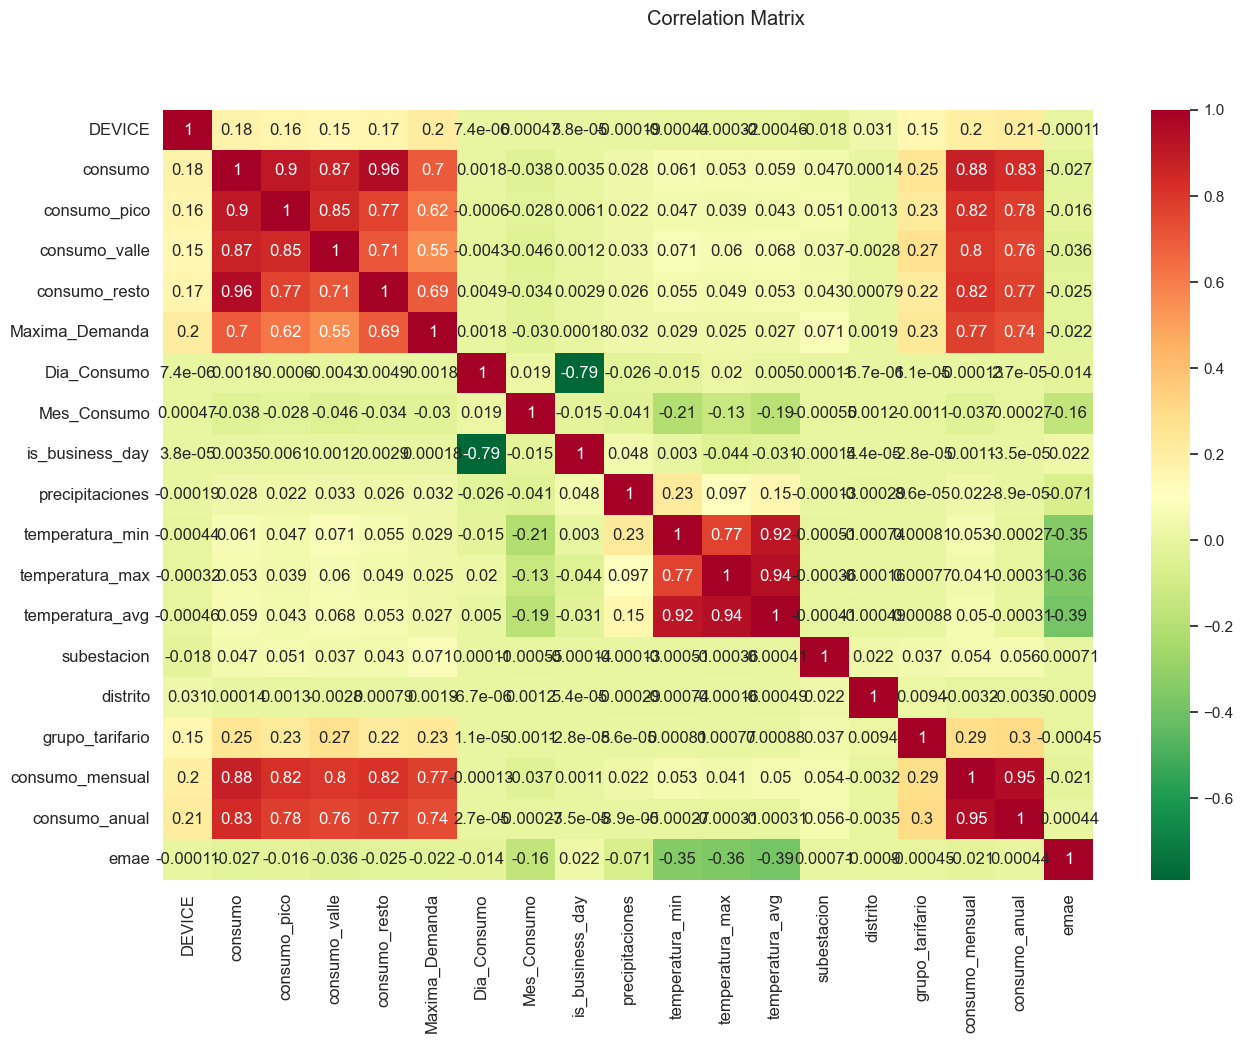

In [1002]:
# Filter numerical data
numeric_data = final_df.select_dtypes(include=['number'])

# Correlation
plt.figure(figsize = (15, 10))
plt.suptitle('Correlation Matrix')
sns.heatmap(numeric_data.corr(), annot=True, cmap='RdYlGn_r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()
plt.close()

### Gráficos de consumos

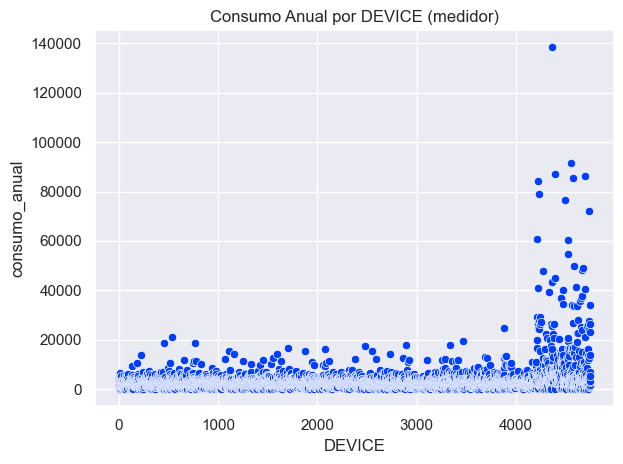

In [1003]:
# Group by device and sum consumption
consumo_anual = final_df.groupby(['DEVICE'], as_index=False)[['consumo_anual']].mean()

# Plot annual consumption by device
sns.scatterplot(consumo_anual, x='DEVICE', y='consumo_anual')

# Customize the chart
plt.title('Consumo Anual por DEVICE (medidor)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [1004]:
# See how many DEVICE have an annual consumption over target
high_consumers = consumo_anual.loc[consumo_anual['consumo_anual']>=30000]['DEVICE']

In [1005]:
# Agrupar por DEVICE y calcular la tarifa más frecuente y la suma del consumo diario
segment_group = final_df.groupby('DEVICE').agg({
    'consumo_anual': 'mean', 
    'grupo_tarifario': lambda x: x.mode()[0],
    'tarifa': lambda x: x.mode()[0] 
}).reset_index()

In [1006]:
segment_group.loc[segment_group['DEVICE'].isin(high_consumers)]

,DEVICE,consumo_anual,grupo_tarifario,tarifa
4217,4217.0,60677.573,2.0,2 GENERAL Y DE SERVICIOS
4218,4218.0,84319.951,2.0,2 GENERAL Y DE SERVICIOS
4226,4226.0,41067.672,1.0,1.a/f RESIDENCIAL
4232,4232.0,79081.982,6.0,6.1 ALUMBRADO PUBLICO
4275,4275.0,47961.369,2.0,2 GENERAL Y DE SERVICIOS
4332,4332.0,39380.413,2.0,2 GENERAL Y DE SERVICIOS
4359,4359.0,43528.243,2.0,2 GRAL.y SERV.(c/DISC)
4360,4360.0,138336.239,2.0,2 GRAL.y SERV.(c/DISC)
4392,4392.0,86946.855,2.0,2 GENERAL Y DE SERVICIOS
4393,4393.0,45042.042,2.0,2 GENERAL Y DE SERVICIOS


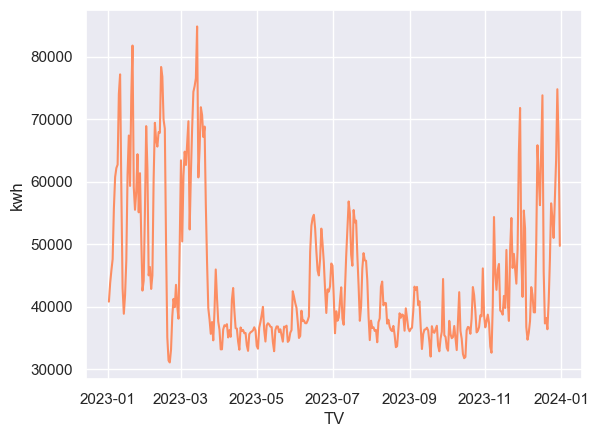

In [1007]:
# Group by date and sum consumption
daily_consumption = final_df.groupby(['TV'], as_index=False)[['consumo']].sum()

# Reshape a DataFrame from a wide format to a long format
daily_consumption = pd.melt(daily_consumption, ['TV'], value_name='kwh')

# Plot
sns.lineplot(data=daily_consumption, x='TV', y='kwh', color='#fc8d62')
plt.show()

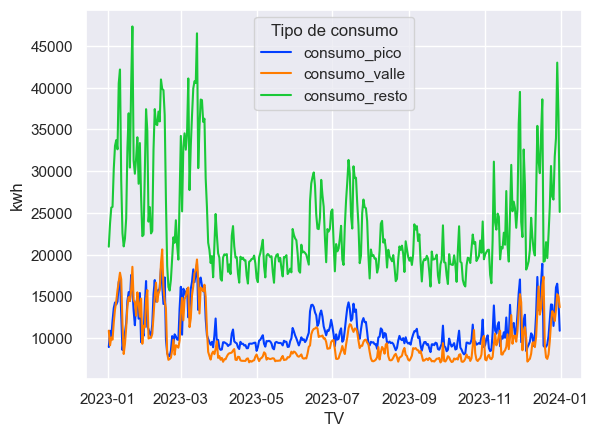

In [1008]:
# Group by date and sum consumption in each range
range = ['consumo_pico','consumo_valle','consumo_resto']
consumption_by_range = final_df.groupby(['TV'], as_index=False)[range].sum()

# Reshape a DataFrame from a wide format to a long format
consumption_by_range = pd.melt(consumption_by_range, ['TV'], var_name='Tipo de consumo', value_name='kwh')

# Plot
sns.lineplot(data=consumption_by_range, x='TV', y='kwh', hue='Tipo de consumo')
plt.show()

Veamos la relación entre los grupos tarifarios y las tarifas:

<Axes: xlabel='grupo_tarifario', ylabel='tarifa'>

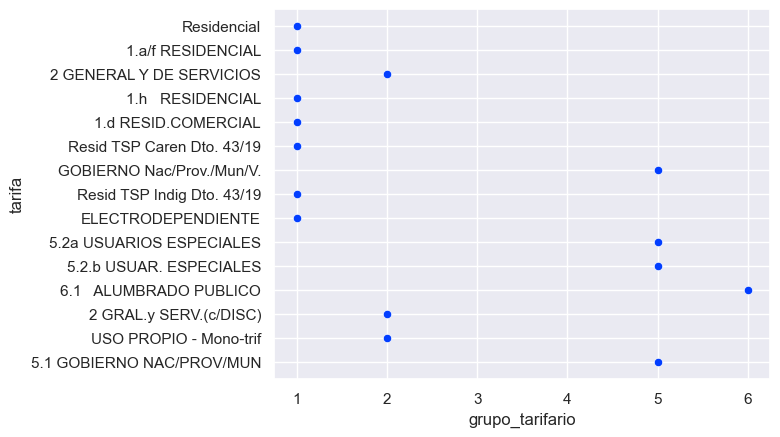

In [1009]:
sns.scatterplot(data=qgis, x='grupo_tarifario', y='tarifa')

Vamos la relación entre las rutas de lectura y los grupos de lectura:

<Axes: xlabel='grupo_lectura', ylabel='ruta_lectura'>

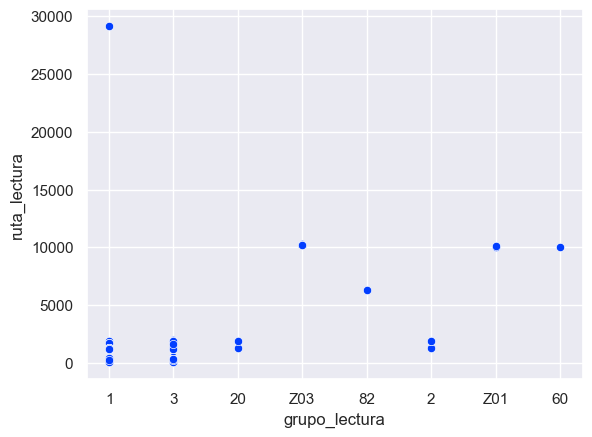

In [1010]:
sns.scatterplot(data=qgis, x='grupo_lectura', y='ruta_lectura')

### Gráficos de información climática

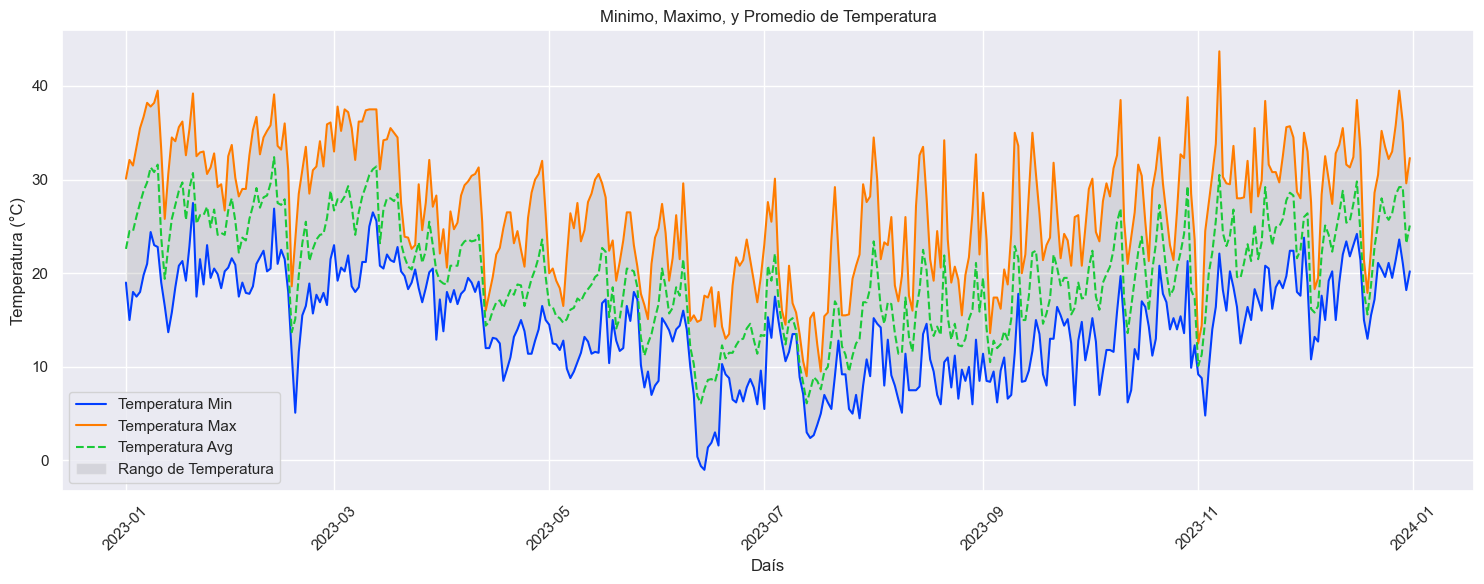

In [1011]:
# Define variables for the chart
dates = clima_df['Fecha']  # Column with dates (days)
min_temp = clima_df['temperatura_min']
max_temp = clima_df['temperatura_max']
avg_temp = clima_df['temperatura_avg']

# Create the line chart
plt.figure(figsize=(15, 6))

# Create the lines for minimum and maximum temperature
plt.plot(dates, min_temp, label='Temperatura Min')
plt.plot(dates, max_temp, label='Temperatura Max')
plt.plot(dates, avg_temp, label='Temperatura Avg', linestyle='--')

# Shade the area between the curves
plt.fill_between(dates, min_temp, max_temp, where=(min_temp <= max_temp), facecolor='gray', alpha=0.2, label='Rango de Temperatura')

# Customize the chart
plt.xlabel('Daís')
plt.ylabel('Temperatura (°C)')
plt.title('Minimo, Maximo, y Promedio de Temperatura')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Primeros vistazos de la relación entre el consumo diario y los factores climáticos

In [1012]:
# Drop specific column
daily_consumption = daily_consumption.drop('variable', axis=1)
# Rename column
daily_consumption.rename(columns={'kwh': 'daily_consumption'}, inplace=True)

In [1013]:
# Add daily consumption information to our weather dataset
consumption_weather = daily_consumption.merge(clima_df, how='left', left_on='TV', right_on='Fecha')

# Delete 'Fecha' column (duplicated)
consumption_weather.drop(columns=['TV'], inplace=True)

# Reorder columns
new_order = ['Fecha', 'daily_consumption', 'precipitaciones', 'temperatura_min','temperatura_max','temperatura_avg']
consumption_weather = consumption_weather.reindex(columns=new_order)

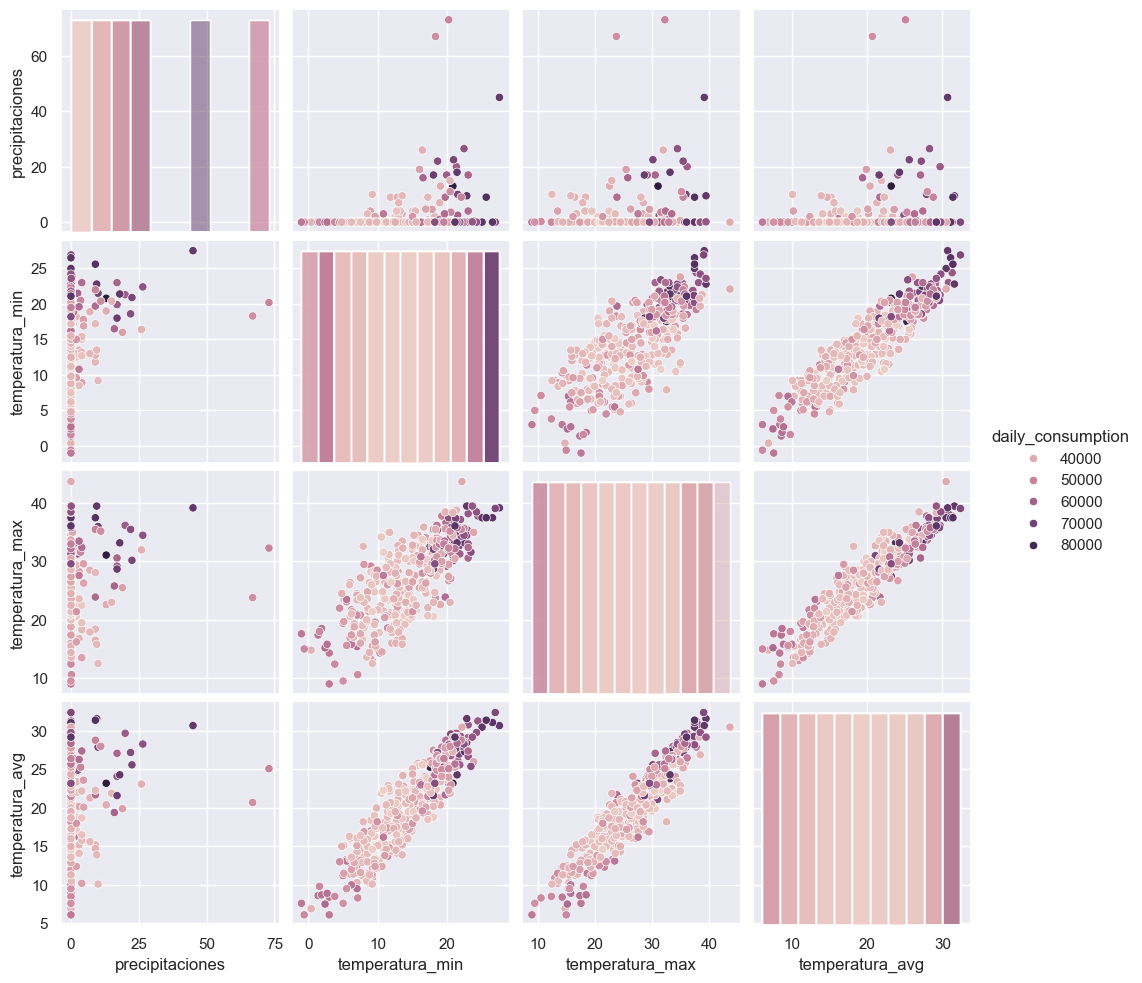

In [1014]:
sns.pairplot(consumption_weather, hue="daily_consumption", diag_kind="hist")

In [1015]:
# Filter numerical columns
numeric_col = consumption_weather.select_dtypes(include=['number']).columns

# Calculate correlation between consumption and other variables
consumption_weather[numeric_col].corr()['daily_consumption'].sort_values()

precipitaciones      0.218376
temperatura_max      0.402449
temperatura_avg      0.446266
temperatura_min      0.468265
daily_consumption    1.000000
Name: daily_consumption, dtype: float64

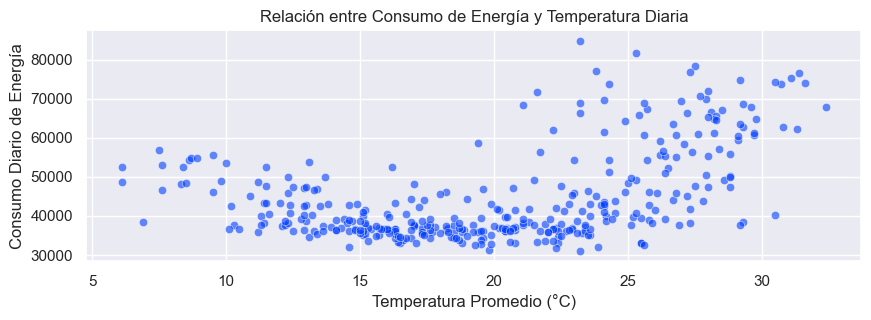

In [1016]:
# Crear gráfico de dispersión
plt.figure(figsize=(10, 3))
plt.scatter(consumption_weather['temperatura_avg'], consumption_weather['daily_consumption'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('Temperatura Promedio (°C)')
plt.ylabel('Consumo Diario de Energía')
plt.title('Relación entre Consumo de Energía y Temperatura Diaria')
plt.grid(True)
plt.show()

*💡 OBSERVACIONES*

- Se puede ver en los gráficos y mismo conociendo la correlación la influencia de la temperatura en el consumo energético.

### Estadísticos de consumo por grupo tarifario

In [1017]:
# Create empty dictionaries to store the statistics
mean_dict = {}
median_dict = {}
std_dict = {}

# Iterate through unique 'grupo_tarifario' values
for grupo_tarifario in final_df['grupo_tarifario'].unique():
    # Filter data for the current 'grupo_tarifario'
    group_df = final_df[final_df['grupo_tarifario'] == grupo_tarifario]

    # Calculate the mean, median, mode, and standard deviation
    mean_value = group_df['consumo'].mean()
    median_value = group_df['consumo'].median()
    std_value = group_df['consumo'].std()

    # Store the values in the dictionaries
    mean_dict[grupo_tarifario] = mean_value
    median_dict[grupo_tarifario] = median_value
    std_dict[grupo_tarifario] = std_value

# Print the statistics for each 'grupo_tarifario'
for grupo_tarifario, mean_value, median_value, std_value in zip(mean_dict, mean_dict.values(), median_dict.values(), std_dict.values()):
    print(f"Grupo tarifario: {grupo_tarifario}")
    print(f"Media de consumo: {mean_value} kwh")
    print(f"Mediana: {median_value} kwh")
    print(f"Desviación estándar: {std_value} kwh")
    print("\n")  # Add a newline after each group's statistics

Grupo tarifario: 1.0
Media de consumo: 7.594366340342639 kwh
Mediana: 5.548999999999978 kwh
Desviación estándar: 9.711370539654963 kwh


Grupo tarifario: 2.0
Media de consumo: 23.413598749670307 kwh
Mediana: 7.390999999999622 kwh
Desviación estándar: 45.39080351643263 kwh


Grupo tarifario: 5.0
Media de consumo: 25.629944677769732 kwh
Mediana: 8.714999999999236 kwh
Desviación estándar: 36.787882968046596 kwh


Grupo tarifario: 6.0
Media de consumo: 39.6730540130481 kwh
Mediana: 27.299000000000888 kwh
Desviación estándar: 53.617773282422064 kwh




Gráfico de consumo diario

In [1018]:
# Hago un groupby: grupo_tarifario para plotear
consumo_grupo_tarifario = final_df.groupby(['TV','grupo_tarifario','temperatura_max','temperatura_min','temperatura_avg','precipitaciones','Dia_Consumo','Mes_Consumo','is_business_day','emae'], as_index=False)[['consumo','Maxima_Demanda']].sum()

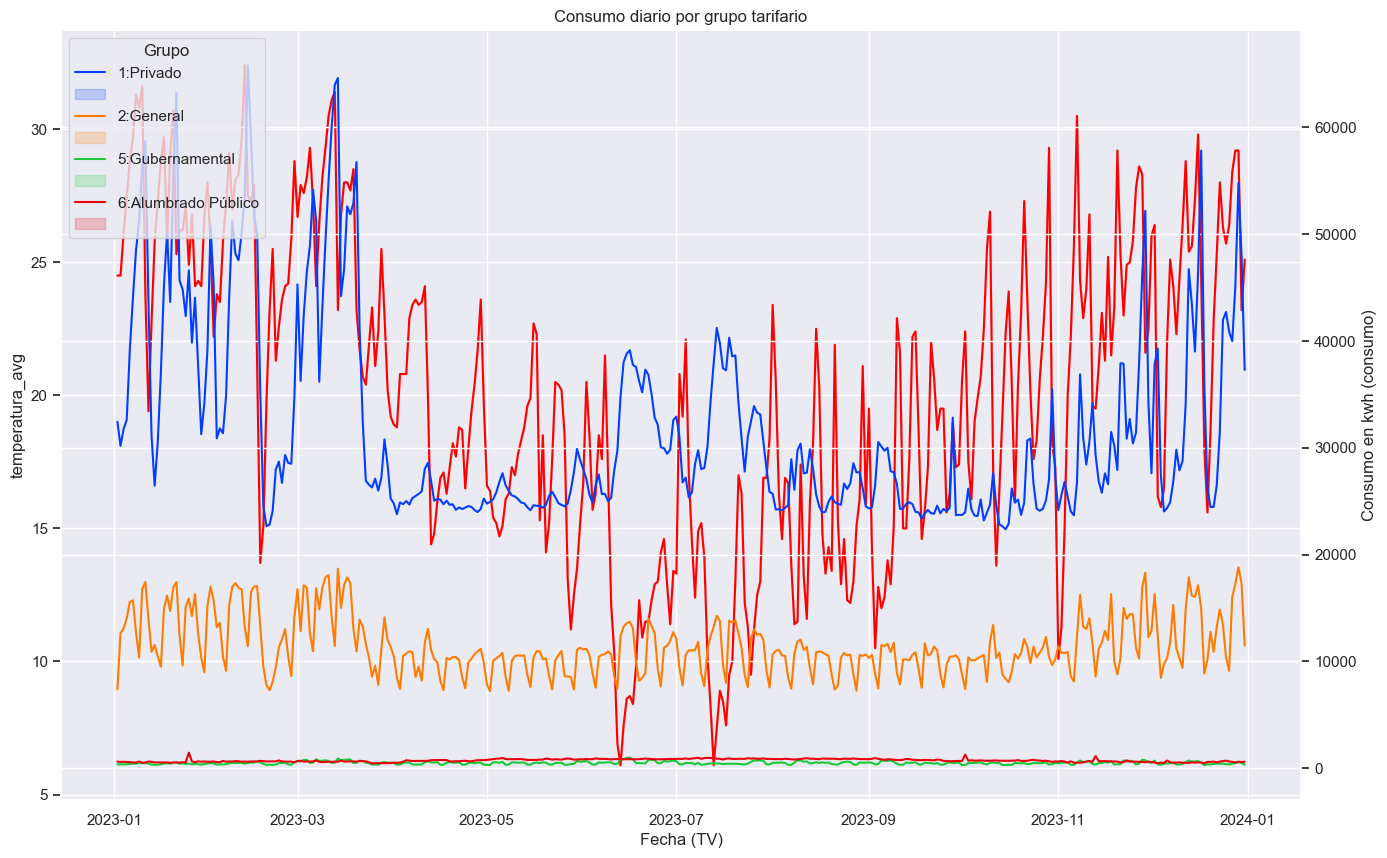

In [1019]:
# Identificar la causa de los picos, valles y consumos medios.

fig, ax = plt.subplots(figsize=(16, 10))

# Variable: Temperatura
sns.lineplot(x="TV", y="temperatura_avg",
             data=consumo_grupo_tarifario, ax=ax, color='red')
ax2 = ax.twinx()

# Target: consumo
sns.lineplot(x="TV", y="consumo",
             hue="grupo_tarifario",
             data=consumo_grupo_tarifario, ax=ax2, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (TV)',
       title='Consumo diario por grupo tarifario')
ax2.set(ylabel='Consumo en kwh (consumo)')
plt.legend(title='Grupo', loc='upper left', labels=['1:Privado', '','2:General','', '5:Gubernamental', '','6:Alumbrado Público',''])
plt.show()

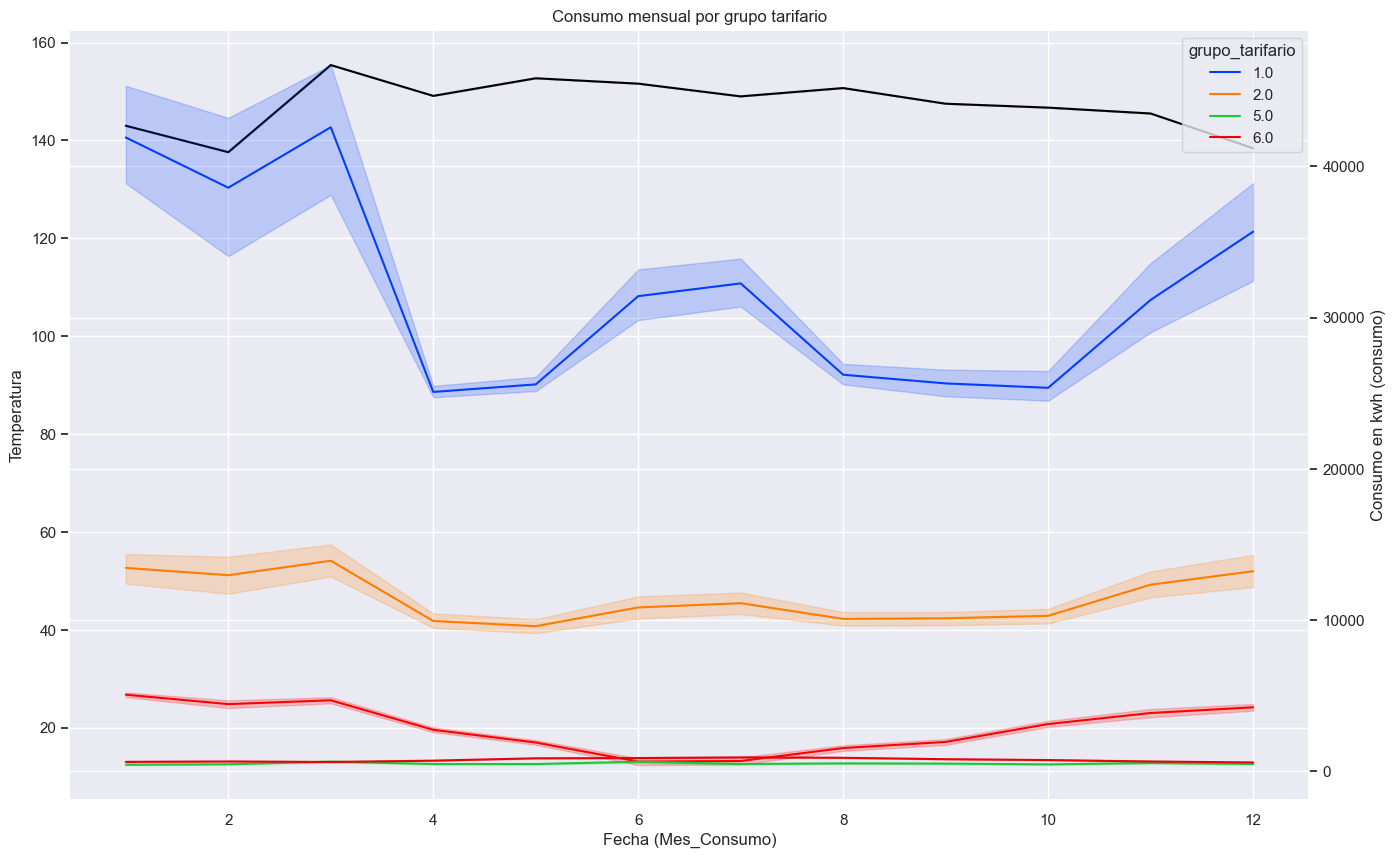

In [1021]:
# Identificar la causa de los picos, valles y consumos medios.

fig, ax = plt.subplots(figsize=(16, 10))

# Variable: Temperatura Promedio
sns.lineplot(x="Mes_Consumo", y="temperatura_avg",
             data=consumo_grupo_tarifario, ax=ax, color='red')

# Variable: emae
sns.lineplot(x="Mes_Consumo", y="emae",
             data=consumo_grupo_tarifario, ax=ax, color='black')
ax2 = ax.twinx()

# Consumo
sns.lineplot(x="Mes_Consumo", y="consumo",
             hue="grupo_tarifario", 
             data=consumo_grupo_tarifario, ax=ax2, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (Mes_Consumo)',
       ylabel='Temperatura',
       title='Consumo mensual por grupo tarifario')
ax2.set(ylabel='Consumo en kwh (consumo)')

plt.show()

---

Guardo modelo obtenido

In [ ]:
# nombre de archivo
csv_file = 'modelo_epec.csv'

# grabar los datos
final_df.to_csv(csv_file, sep=';', index=False)